In [2]:
import os, math
from collections import defaultdict, namedtuple, deque
import dataclasses
from dataclasses import dataclass
import itertools
from enum import StrEnum, auto
import sqlite3
import logging
import logging.handlers
import pickle
import datetime
import multiprocessing as mp
import gc

from PIL import Image, ImageDraw
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy
import numpy as np
import cupy as cp
import pandas as pd

from module.utils import *
from module.hdc import *
from module.constants import *

In [3]:
LOG = Logging()

config_var = 'SQLITE3_SEQ_GRID_0_2_4096'
config = Config(config_var)
RNG = np.random.default_rng()
mp_ctx = mp.get_context('spawn') # req-d for CUPY to work, 'fork' method leads to failures in bootstrap somewhere around CUDA

if cp.cuda.is_available():
    xp = cp.get_array_module(cp.empty(1))
    xp_array_from_gpu = lambda a: a.get() if isinstance(a, cp.ndarray) else a
    xp_array_to_gpu = lambda a: cp.asarray(a) if isinstance(a, np.ndarray) else a
    xp_array_to_gpu_copy = lambda a: cp.asarray(a) if isinstance(a, np.ndarray) else a
else:
    xp = cp.get_array_module(np.empty(1))
    xp_array_from_gpu = lambda a: a
    xp_array_to_gpu = lambda a: a
    xp_array_to_gpu_copy = lambda a: a.copy()

print(f'xp = {xp.__name__}')

hdc = Hdc(10_000, xp)

xp = numpy


In [4]:
%run sequencing_sp2.ipynb

# Open DB

In [5]:
%time
train_db_con = sqlite3.connect(DBUtils.get_full_db_file_name(config, config.train_db_file_name))
test_db_con = sqlite3.connect(DBUtils.get_full_db_file_name(config, config.test_db_file_name))
test_results_db_con = sqlite3.connect(DBUtils.get_full_db_file_name(config, config.test_results_db_file_name, with_prefix=False), autocommit=True)

if not DBUtils.is_table_exists(test_results_db_con, 'test_runs'):
    test_results_db_con.execute('CREATE TABLE test_runs(test_run_id INTEGER PRIMARY KEY, dummy)')

df_train_images = pd.read_sql_query('SELECT * FROM images', con=train_db_con, index_col='image_id')
df_test_images = pd.read_sql_query('SELECT * FROM images', con=test_db_con, index_col='image_id')
df_train_images.shape, df_test_images.shape

CPU times: user 1 μs, sys: 0 ns, total: 1 μs
Wall time: 3.81 μs


((10000, 7), (2000, 7))


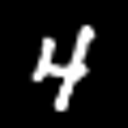
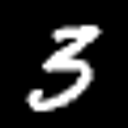
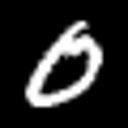
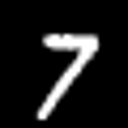
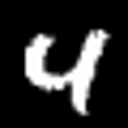
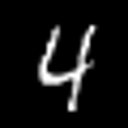
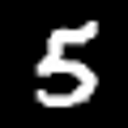
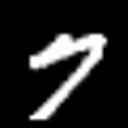
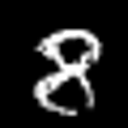
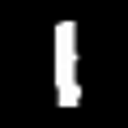
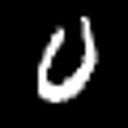
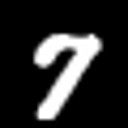
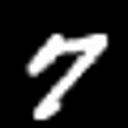
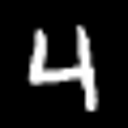
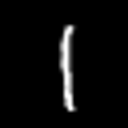
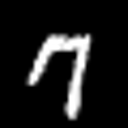

In [6]:
count = 8

def get_images_and_labels(df, ids):
    image_datas = df.loc[ids]['png']
    images = [Image.open(io.BytesIO(image_data)) for image_data in image_datas]
    labels = df.loc[ids]['value']
    return images, list(labels)

def get_some_random_images_and_labels(df, count):
    image_ids = RNG.choice(df.index.unique(), count, replace=False)
    return get_images_and_labels(df, image_ids)

train_images, train_labels = get_some_random_images_and_labels(df_train_images, count)
test_images, test_labels = get_some_random_images_and_labels(df_test_images, count)

display_images_grid(train_images + test_images, captions=train_labels + test_labels, col_count=count)

# Core logic

## Types

In [7]:
SeqLatentVecMeta = namedtuple('SeqLatentVec', ['engram_id', 'phase', 'seq_lv_code', 'seq', 'seq_lv_ind'])
Engram = namedtuple('Engram', ['engram_id', 'image_id', 'value', 'seq_lv_inds', 'si_ind_dict'])
Matchee = namedtuple('Matchee', ['seqs', 'seq_lvs', 'seq_lvs2',  'seq_lv_codes', 'si_ind_dict'])
# Matchee = namedtuple('Matchee', ['seqs', 'seq_lvs_cos_sim', 'seq_lvs_corr', 'seq_lvs_diff_sq', 'seq_lv_codes', 'si_ind_dict'])
# Matchee = namedtuple('Matchee', ['seqs', 'seq_lvs_cos_sim', 'seq_lvs_diff_sq', 'seq_lv_codes', 'si_ind_dict'])

## memory

In [8]:
def grow_seq_lv_array(current_array_size):
    if current_array_size < 15000:
        return current_array_size * 2

    return current_array_size + 5000

SEQ_INGRESS_SUBLV_LEN = 150
SEQ_SEQ_SUBLV_LEN = 300
SEQ_SUBLV_LEN = SEQ_INGRESS_SUBLV_LEN + SEQ_SEQ_SUBLV_LEN
SEQ_SUBLVS_COUNT = 5
SEQ_LV_LEN = SEQ_SUBLV_LEN * SEQ_SUBLVS_COUNT
SEQ_LVS = HdvArray(SEQ_LV_LEN * 2, xp, dtype='f', grow_policy=grow_seq_lv_array)
SEQ_LVS2 = HdvArray(SEQ_LV_LEN * 2, np, dtype='f', grow_policy=grow_seq_lv_array)
# SEQ_LVS_COS_SIM = HdvArray(SEQ_LV_LEN * 2, xp)
# SEQ_LVS_CORR = HdvArray(SEQ_LV_LEN * 2, xp)
# SEQ_LVS_DIFF_SQ = HdvArray(SEQ_LV_LEN * 2 * 2, xp)
SEQ_LV_IND_TO_META = {} # key - index in SEQ_LVS, value - SeqLatentVecMeta
ENGRAMS = {} # key - engram id, value - engram instance
ENGRAM_ID_SOURCE = itertools.count(1)

In [9]:
def gc_memory():
    gc.collect()
    
    if cp.cuda.is_available():
        cp.get_default_memory_pool().free_all_blocks()

def clear_memory():
    SEQ_LVS.clear()
    SEQ_LVS2.clear()
    # SEQ_LVS_COS_SIM.clear()
    # SEQ_LVS_CORR.clear()
    # SEQ_LVS_DIFF_SQ.clear()
    SEQ_LV_IND_TO_META.clear()
    ENGRAMS.clear()
    gc_memory()

## lambdas

In [10]:
expand_normal_vec = lambda j: (j.real, j.imag)
fetch_si_xy = lambda si: (si.x, si.y)
get_sequence = lambda sequences: np.array(list(itertools.chain.from_iterable(sequences)))
get_normal_sequence = lambda sequence, si_ind_dict: np.array(list(map(lambda si_ind: expand_normal_vec(si_ind_dict[si_ind].normal_vec), sequence)))
get_xy_sequence = lambda sequence, si_ind_dict: np.array(list(map(lambda si_ind: fetch_si_xy(si_ind_dict[si_ind]), sequence)))

## render_image

In [11]:
def render_image(image_id, df_images, image_sz=(600, 600)):
    df_image = df_images.loc[image_id]
    image_png = df_image['png']
    image = Image.open(io.BytesIO(image_png))
    image = image.convert('RGB')
    k = image.size[0]
    image = image.resize(image_sz)
    k = image.size[0] / k
    image_draw = ImageDraw.Draw(image)

    inner_si_ind_dict = pickle.loads(df_image['inner_si_ind_dict'])
    inner_sequences = pickle.loads(df_image['inner_sequences'])
        
    for seq in inner_sequences:
        for si_ind_from, si_ind_to in zip(seq, seq[1:]):
            si_from = inner_si_ind_dict[si_ind_from]
            si_to = inner_si_ind_dict[si_ind_to]
            pt_from = si_from.x * k, si_from.y * k
            pt_to = si_to.x * k, si_to.y * k
            image_draw.line([pt_from[0], pt_from[1], pt_to[0], pt_to[1]], width=1, fill='red')
            
            nl = 6 * k
            image_draw.rectangle([pt_from[0]-1, pt_from[1]-1, pt_from[0]+1, pt_from[1]+1], outline='red')
            normal_vec = si_from.normal_vec
            image_draw.line([pt_from[0], pt_from[1], pt_from[0] + normal_vec.real * nl, pt_from[1] + normal_vec.imag * nl], width=1, fill='red')
            image_draw.text([pt_from[0] + normal_vec.real * nl*1.2, pt_from[1] + normal_vec.imag * nl*1.2], str(si_ind_from), anchor='mm', fill='red')

            image_draw.rectangle([pt_to[0]-1, pt_to[1]-1, pt_to[0]+1, pt_to[1]+1], outline='red')
            normal_vec = si_to.normal_vec
            image_draw.line([pt_to[0], pt_to[1], pt_to[0] + normal_vec.real * nl, pt_to[1] + normal_vec.imag * nl], width=1, fill='red')
            image_draw.text([pt_to[0] + normal_vec.real * nl*1.2, pt_to[1] + normal_vec.imag * nl*1.2], str(si_ind_to), anchor='mm', fill='red')

    return image

## calc_seqs_latent_vector

In [12]:
def calc_seqs_latent_vector(sequences, si_ind_dict, seq_sublv_cache={}):
    seq_lv = np.zeros((SEQ_SUBLVS_COUNT, SEQ_SUBLV_LEN, 2), dtype='f')
    assert sequences
    assert len(sequences) <= SEQ_SUBLVS_COUNT

    xy_prev_seq_tail = np.zeros(2)
    
    for sequence_i, (sequence, sublv) in enumerate(zip(sequences, seq_lv)):
        ingress_sublv = sublv[:SEQ_INGRESS_SUBLV_LEN]
        seq_sublv = sublv[SEQ_INGRESS_SUBLV_LEN:]
        
        assert sequence
        xy_sequence = get_xy_sequence(sequence, si_ind_dict)
        xy_sequence0 = xy_sequence[0].copy()
        xy_sequence_last = xy_sequence[-1].copy()
        xy_sequence -= xy_sequence0
        
        # 1) Ingress component of sublv, for very first sequence (sublv) there is no ingress 
        if sequence_i > 0:
            ingress_vec = xy_sequence0 - xy_prev_seq_tail
            ingress_vec_len = int(np.round(np.linalg.norm(ingress_vec), decimals=0))
    
            if ingress_vec_len > 0:
                assert ingress_vec_len <= ingress_sublv.shape[0], ingress_vec_len
                ingress_sublv[:ingress_vec_len] = ingress_vec / ingress_vec_len
    
        # Remember tip last position so we would be able to compute
        # ingress vec for next seq RELATIVELY!!! (from tail to tip, not from beginning of whole figure)
        xy_prev_seq_tail = xy_sequence_last

        # 2) Seq component of sublv. 
        # At first check in cache - chances are that we've already done computation of seq_sublv.
        # Key for cache is starting si_ind. The bid here is that we have no duplicate si_ind within figure, 
        # as such each sub_lv is uniquely identified by starting si_ind
        starting_si_ind = sequence[0]

        if starting_si_ind in seq_sublv_cache:
            seq_sublv[:] = seq_sublv_cache[starting_si_ind]
        else:
            vec_sequence = np.array(list(map(lambda xy_pair: (xy_pair[1][0] - xy_pair[0][0], xy_pair[1][1] - xy_pair[0][1]), 
                                         zip(xy_sequence, np.roll(xy_sequence, -1, axis=0)))))
            vec_sequence[-1,:] = 0 # get rid of reciprocal vector which connects tail to tip
            vec_len_sequence = np.linalg.norm(vec_sequence, axis=1)
            vec_len_sequence_nozero = np.where(vec_len_sequence != 0, vec_len_sequence, 1e-6) # prevent 0 len vectors
            norm_vec_sequence = (vec_sequence.T / vec_len_sequence_nozero).T
            
            assert len(sequence) == vec_sequence.shape[0]
            assert len(sequence) == vec_len_sequence.shape[0]
            assert len(sequence) == norm_vec_sequence.shape[0]
            
            seq_len = vec_len_sequence.sum()
    
            if seq_len > 0:
                assert seq_len <= seq_sublv.shape[0]
                
                i = 0
                i_from = 0
                i_to = 0
        
                for si_ind, norm_vec, vec_len in zip(sequence, norm_vec_sequence, vec_len_sequence):
                    if vec_len > 0:
                        i += vec_len
                        i_to = min(int(i), seq_sublv.shape[0])
                        assert i_from >= 0, i_from
                        assert i_to >= i_from, (i_to, i_from)
                        assert i_to <= seq_sublv.shape[0], (i_to, seq_sublv.shape[0])
                        i_to2 = i_to
                        
                        if si_ind == sequence[-1]: # last element - span to the end (due to rounding sometimes i_to may not be exactly positioned at last index
                            i_to2 = seq_sublv.shape[0]
                
                        seq_sublv[i_from:i_to2] = norm_vec
                    
                    i_from = i_to
                
                    if i_to >= seq_sublv.shape[0]:
                        break
    
            seq_sublv_cache[starting_si_ind] = seq_sublv.copy() 
    
    seq_lv = seq_lv.ravel()
    seq_lv_len = np.linalg.norm(seq_lv)
    return seq_lv / seq_lv_len, seq_lv

In [13]:
def calc_seqs_latent_vector7(sequences, si_ind_dict):
    seq_lv = np.zeros((SEQ_SUBLVS_COUNT, SEQ_SUBLV_LEN, 2), dtype='f')
    assert sequences
    assert len(sequences) <= SEQ_SUBLVS_COUNT

    xy_prev_seq_tail = np.zeros(2)
    
    for sequence_i, (sequence, sublv) in enumerate(zip(sequences, seq_lv)):
        ingress_sublv = sublv[:SEQ_INGRESS_SUBLV_LEN]
        seq_sublv = sublv[SEQ_INGRESS_SUBLV_LEN:]
        
        assert sequence
        xy_sequence = get_xy_sequence(sequence, si_ind_dict)
        xy_sequence0 = xy_sequence[0].copy()
        xy_sequence_last = xy_sequence[-1].copy()
        xy_sequence -= xy_sequence0
        vec_sequence = np.array(list(map(lambda xy_pair: (xy_pair[1][0] - xy_pair[0][0], xy_pair[1][1] - xy_pair[0][1]), 
                                         zip(xy_sequence, np.roll(xy_sequence, -1, axis=0)))))
        vec_sequence[-1,:] = 0 # get rid of reciprocal vector which connects tail to tip
        vec_len_sequence = np.linalg.norm(vec_sequence, axis=1)
        vec_len_sequence_nozero = np.where(vec_len_sequence != 0, vec_len_sequence, 1e-6) # prevent 0 len vectors
        norm_vec_sequence = (vec_sequence.T / vec_len_sequence_nozero).T
        
        assert len(sequence) == vec_sequence.shape[0]
        assert len(sequence) == vec_len_sequence.shape[0]
        assert len(sequence) == norm_vec_sequence.shape[0]
        
        seq_len = vec_len_sequence.sum()

        if seq_len == 0:
            continue
            
        assert seq_len <= seq_sublv.shape[0]

        # Ingress component of sublv
        if sequence_i > 0:
            ingress_vec = xy_sequence0 - xy_prev_seq_tail
            ingress_vec_len = int(np.round(np.linalg.norm(ingress_vec), decimals=0))
    
            if ingress_vec_len > 0:
                assert ingress_vec_len <= ingress_sublv.shape[0], ingress_vec_len
                ingress_sublv[:ingress_vec_len] = ingress_vec / ingress_vec_len
    
        # Remember tip last position so we would be able to compute
        # ingress vec for next seq RELATIVELY!!! (from tail to tip, not from beginning of whole figure)
        xy_prev_seq_tail = xy_sequence_last

        # Seq component of sublv
        i = 0
        i_from = 0
        i_to = 0

        for si_ind, norm_vec, vec_len in zip(sequence, norm_vec_sequence, vec_len_sequence):
            if vec_len > 0:
                i += vec_len
                i_to = min(int(i), seq_sublv.shape[0])
                assert i_from >= 0, i_from
                assert i_to >= i_from, (i_to, i_from)
                assert i_to <= seq_sublv.shape[0], (i_to, seq_sublv.shape[0])
                i_to2 = i_to
                
                if si_ind == sequence[-1]: # last element - span to the end (due to rounding sometimes i_to may not be exactly positioned at last index
                    i_to2 = seq_sublv.shape[0]
        
                seq_sublv[i_from:i_to2] = norm_vec
            
            i_from = i_to
        
            if i_to >= seq_sublv.shape[0]:
                break
    
    seq_lv = seq_lv.ravel()
    seq_lv_len = np.linalg.norm(seq_lv)
    return seq_lv / seq_lv_len, seq_lv

In [14]:
def calc_seqs_latent_vector6(sequences, si_ind_dict):
    seq_lv = np.zeros((SEQ_SUBLVS_COUNT, SEQ_SUBLV_LEN, 2))
    assert sequences
    assert len(sequences) <= SEQ_SUBLVS_COUNT

    pivot_pt = fetch_si_xy(si_ind_dict[sequences[0][0]])
    
    for sequence, seq_sublv in zip(sequences, seq_lv):
        assert sequence
        xy_sequence = get_xy_sequence(sequence, si_ind_dict)
        xy_sequence0 = xy_sequence[0].copy()
        xy_sequence -= xy_sequence0
        vec_sequence = np.array(list(map(lambda xy_pair: (xy_pair[1][0] - xy_pair[0][0], xy_pair[1][1] - xy_pair[0][1]), 
                                         zip(xy_sequence, np.roll(xy_sequence, -1, axis=0)))))
        vec_sequence[-1,:] = 0 # get rid of reciprocal vector which connects tail to tip
        vec_len_sequence = np.linalg.norm(vec_sequence, axis=1)
        vec_len_sequence_nozero = np.where(vec_len_sequence != 0, vec_len_sequence, 1e-6) # prevent 0 len vectors
        norm_vec_sequence = (vec_sequence.T / vec_len_sequence_nozero).T
        
        assert len(sequence) == vec_sequence.shape[0]
        assert len(sequence) == vec_len_sequence.shape[0]
        assert len(sequence) == norm_vec_sequence.shape[0]
        
        seq_len = vec_len_sequence.sum()

        if seq_len == 0:
            continue
            
        assert seq_len <= seq_sublv.shape[0]
        
        i = 0
        i_from = 0
        i_to = 0
            
        for si_ind, norm_vec, vec_len in zip(sequence, norm_vec_sequence, vec_len_sequence):
            if vec_len > 0:
                i += vec_len
                i_to = min(int(i), seq_sublv.shape[0])
                assert i_from >= 0, i_from
                assert i_to >= i_from, (i_to, i_from)
                assert i_to <= seq_sublv.shape[0], (i_to, seq_sublv.shape[0])
                i_to2 = i_to
                
                if si_ind == sequence[-1]: # last element - span to the end (due to rounding sometimes i_to may not be exactly positioned at last index
                    i_to2 = seq_sublv.shape[0]
        
                seq_sublv[i_from:i_to2] = norm_vec
            
            i_from = i_to
        
            if i_to >= seq_sublv.shape[0]:
                break

        # Put ingress vector (aka offset of this sequence) on tip of latent vector. This way we would be able to 
        # account for differences in locations of sequences
        seq_sublv[:] = np.roll(seq_sublv, 1, axis=0)
        seq_sublv[0] = xy_sequence0 - pivot_pt # Works bad!, because of RNG.normal(-5, 0.1, 100) syndrom (<- such two random vectors will have cos sim near 1)

    seq_lv = seq_lv.ravel()
    seq_lv_len = np.linalg.norm(seq_lv)
    return seq_lv / seq_lv_len, seq_lv

In [15]:
def calc_seqs_latent_vector5(sequences, si_ind_dict):
    seq_lv = np.zeros((SEQ_SUBLVS_COUNT, SEQ_SUBLV_LEN, 2))
    assert sequences
    assert len(sequences) <= SEQ_SUBLVS_COUNT

    pivot_pt = fetch_si_xy(si_ind_dict[sequences[0][0]])
    
    for sequence, seq_sublv in zip(sequences, seq_lv):
        assert sequence
        xy_sequence = get_xy_sequence(sequence, si_ind_dict)
        xy_sequence0 = xy_sequence[0].copy()
        xy_sequence -= xy_sequence0
        vec_sequence = np.array(list(map(lambda xy_pair: (xy_pair[1][0] - xy_pair[0][0], xy_pair[1][1] - xy_pair[0][1]), 
                                         zip(xy_sequence, np.roll(xy_sequence, -1, axis=0)))))
        vec_sequence[-1,:] = 0 # get rid of reciprocal vector which connects tail to tip
        vec_len_sequence = np.linalg.norm(vec_sequence, axis=1)
        vec_len_sequence_nozero = np.where(vec_len_sequence != 0, vec_len_sequence, 1e-6) # prevent 0 len vectors
        norm_vec_sequence = (vec_sequence.T / vec_len_sequence_nozero).T
        
        assert len(sequence) == vec_sequence.shape[0]
        assert len(sequence) == vec_len_sequence.shape[0]
        assert len(sequence) == norm_vec_sequence.shape[0]
        
        seq_len = vec_len_sequence.sum()

        if seq_len == 0:
            continue
            
        assert seq_len <= seq_sublv.shape[0] # TODO: weak point if e.g. there is only one but very long sequence, think about it
        k = seq_sublv.shape[0] / seq_len # coeff to make sequence occupy whole sublv (stretch / shrink)
        
        i = 0
        i_from = 0
        i_to = 0
        pt = xy_sequence[0]
            
        for j, (si_ind, norm_vec, vec_len) in enumerate(zip(sequence, norm_vec_sequence, vec_len_sequence)):
            if vec_len > 0:
                i += vec_len
                i_to = min(int(i * k), seq_sublv.shape[0])
                assert i_from >= 0, i_from
                assert i_to >= i_from, (i_to, i_from)
                assert i_to <= seq_sublv.shape[0], (i_to, seq_sublv.shape[0])
                i_to2 = i_to
                
                if si_ind == sequence[-1]: # last element - span to the end (due to rounding sometimes i_to may not be exactly positioned at last index
                    i_to2 = seq_sublv.shape[0]
        
                pts = pt + (np.arange(1, i_to2 - i_from + 1) * norm_vec[np.newaxis,:].T).T # path interpolation
                seq_sublv[i_from:i_to2] = pts
                pt = pts[-1]
            
            i_from = i_to
        
            if i_to >= seq_sublv.shape[0]:
                break
        
        # Put offset of this sequence on tip of latent vector. This way we would be able to 
        # account for differences in locations of sequences and the same time it would'nt overflow squared diffs
        seq_sublv[:] = np.roll(seq_sublv, 1, axis=0)
        seq_sublv[0] = xy_sequence0 - pivot_pt
    
    return seq_lv.ravel()

In [16]:
def calc_seqs_latent_vector4(sequences, si_ind_dict):
    seq_lv = np.zeros((SEQ_SUBLVS_COUNT, SEQ_SUBLV_LEN, 2))
    assert sequences
    assert len(sequences) <= SEQ_SUBLVS_COUNT

    pivot_pt = fetch_si_xy(si_ind_dict[sequences[0][0]])
    
    for sequence, seq_sublv in zip(sequences, seq_lv):
        assert sequence
        xy_sequence = get_xy_sequence(sequence, si_ind_dict)
        xy_sequence0 = xy_sequence[0].copy()
        xy_sequence -= xy_sequence0
        vec_sequence = np.array(list(map(lambda xy_pair: (xy_pair[1][0] - xy_pair[0][0], xy_pair[1][1] - xy_pair[0][1]), 
                                         zip(xy_sequence, np.roll(xy_sequence, -1, axis=0)))))
        vec_sequence[-1,:] = 0 # get rid of reciprocal vector which connects tail to tip
        vec_len_sequence = np.linalg.norm(vec_sequence, axis=1)
        vec_len_sequence_nozero = np.where(vec_len_sequence != 0, vec_len_sequence, 1e-6) # prevent 0 len vectors
        norm_vec_sequence = (vec_sequence.T / vec_len_sequence_nozero).T
        
        assert len(sequence) == vec_sequence.shape[0]
        assert len(sequence) == vec_len_sequence.shape[0]
        assert len(sequence) == norm_vec_sequence.shape[0]
        
        seq_len = vec_len_sequence.sum()
        assert seq_len <= seq_sublv.shape[0] # TODO: weak point if e.g. there is only one but very long sequence, think about it
        
        i = 0
        i_from = 0
        i_to = 0
        pt = xy_sequence[0]
            
        for j, (si_ind, norm_vec, vec_len) in enumerate(zip(sequence, norm_vec_sequence, vec_len_sequence)):
            if vec_len > 0:
                i += vec_len
                i_to = min(int(i), seq_sublv.shape[0])
                assert i_from >= 0, i_from
                assert i_to >= i_from, (i_to, i_from)
                assert i_to <= seq_sublv.shape[0], (i_to, seq_sublv.shape[0])
                i_to2 = i_to
                
                if si_ind == sequence[-1]: # last element - span to the end (due to rounding sometimes i_to may not be exactly positioned at last index
                    i_to2 = seq_sublv.shape[0]
        
                pts = pt + (np.arange(1, i_to2 - i_from + 1) * norm_vec[np.newaxis,:].T).T # path interpolation
                seq_sublv[i_from:i_to2] = pts
                pt = pts[-1]
            
            i_from = i_to
        
            if i_to >= seq_sublv.shape[0]:
                break
        
        if i_from < seq_sublv.shape[0] and i_from > 0:
            seq_sublv[i_from:] = 0
    
        # Put offset of this sequence on tip of latent vector. This way we would be able to 
        # account for differences in locations of sequences and the same time it would'nt overflow squared diffs
        seq_sublv[:] = np.roll(seq_sublv, 1, axis=0)
        seq_sublv[0] = xy_sequence0 - pivot_pt
    
    return seq_lv.ravel()

In [17]:
def calc_seqs_latent_vector3(sequences, si_ind_dict):
    seq_lv = np.zeros((SEQ_SUBLVS_COUNT, SEQ_SUBLV_LEN, 2))
    assert sequences
    assert len(sequences) <= SEQ_SUBLVS_COUNT

    pivot_pt = fetch_si_xy(si_ind_dict[sequences[0][0]])
    
    for sequence, seq_sublv in zip(sequences, seq_lv):
        assert sequence
        xy_sequence = get_xy_sequence(sequence, si_ind_dict)
        xy_sequence0 = xy_sequence[0].copy()
        xy_sequence -= xy_sequence0
        vec_sequence = np.array(list(map(lambda xy_pair: (xy_pair[1][0] - xy_pair[0][0], xy_pair[1][1] - xy_pair[0][1]), 
                                         zip(xy_sequence, np.roll(xy_sequence, -1, axis=0)))))
        vec_sequence[-1,:] = 0 # get rid of reciprocal vector which connects tail to tip
        vec_len_sequence = np.linalg.norm(vec_sequence, axis=1)
        vec_len_sequence_nozero = np.where(vec_len_sequence != 0, vec_len_sequence, 1e-6) # prevent 0 len vectors
        norm_vec_sequence = (vec_sequence.T / vec_len_sequence_nozero).T
        
        assert len(sequence) == vec_sequence.shape[0]
        assert len(sequence) == vec_len_sequence.shape[0]
        assert len(sequence) == norm_vec_sequence.shape[0]
        
        seq_len = vec_len_sequence.sum()
        assert seq_len <= seq_sublv.shape[0] # TODO: weak point if e.g. there is only one but very long sequence, think about it
        
        i = 0
        i_from = 0
        i_to = 0
        pt = xy_sequence[0]
            
        for j, (si_ind, norm_vec, vec_len) in enumerate(zip(sequence, norm_vec_sequence, vec_len_sequence)):
            if vec_len > 0:
                i += vec_len
                i_to = min(int(i), seq_sublv.shape[0])
                assert i_from >= 0, i_from
                assert i_to >= i_from, (i_to, i_from)
                assert i_to <= seq_sublv.shape[0], (i_to, seq_sublv.shape[0])
                i_to2 = i_to
                
                if si_ind == sequence[-1]: # last element - span to the end (due to rounding sometimes i_to may not be exactly positioned at last index
                    i_to2 = seq_sublv.shape[0]
        
                pts = pt + (np.arange(1, i_to2 - i_from + 1) * norm_vec[np.newaxis,:].T).T # path interpolation
                seq_sublv[i_from:i_to2] = pts
                pt = pts[-1]
            
            i_from = i_to
        
            if i_to >= seq_sublv.shape[0]:
                break
        
        if i_from < seq_sublv.shape[0] and i_from > 0:
            seq_sublv[i_from:] = seq_sublv[i_from-1]
    
        # Put offset of this sequence on tip of latent vector. This way we would be able to 
        # account for differences in locations of sequences
        seq_sublv[:] = np.roll(seq_sublv, 1, axis=0)
        seq_sublv[0] = xy_sequence0 - pivot_pt
    
    return seq_lv.ravel()

In [18]:
def calc_seqs_latent_vector2(sequences, si_ind_dict):
    seq_lv = np.zeros((SEQ_SUBLVS_COUNT, SEQ_SUBLV_LEN, 2))
    assert sequences
    assert len(sequences) <= SEQ_SUBLVS_COUNT
    
    initial_pt = fetch_si_xy(si_ind_dict[sequences[0][0]])
    
    for sequence, seq_sublv in zip(sequences, seq_lv):
        assert sequence
        xy_sequence = get_xy_sequence(sequence, si_ind_dict)
        xy_sequence -= initial_pt
        vec_sequence = np.array(list(map(lambda xy_pair: (xy_pair[1][0] - xy_pair[0][0], xy_pair[1][1] - xy_pair[0][1]), 
                                         zip(xy_sequence, np.roll(xy_sequence, -1, axis=0)))))
        vec_sequence[-1,:] = 0 # get rid of reciprocal vector which connects tail to tip
        vec_len_sequence = np.linalg.norm(vec_sequence, axis=1)
        vec_len_sequence_nozero = np.where(vec_len_sequence != 0, vec_len_sequence, 1e-6) # prevent 0 len vectors
        norm_vec_sequence = (vec_sequence.T / vec_len_sequence_nozero).T
        
        assert len(sequence) == vec_sequence.shape[0]
        assert len(sequence) == vec_len_sequence.shape[0]
        assert len(sequence) == norm_vec_sequence.shape[0]
        
        seq_len = vec_len_sequence.sum()
        assert seq_len <= seq_sublv.shape[0] # TODO: weak point if e.g. there is only one but very long sequence, think about it
        
        i = 0
        i_from = 0
        i_to = 0
        pt = xy_sequence[0]
            
        for j, (si_ind, norm_vec, vec_len) in enumerate(zip(sequence, norm_vec_sequence, vec_len_sequence)):
            if vec_len > 0:
                i += vec_len
                i_to = min(int(i), seq_sublv.shape[0])
                assert i_from >= 0, i_from
                assert i_to >= i_from, (i_to, i_from)
                assert i_to <= seq_sublv.shape[0], (i_to, seq_sublv.shape[0])
                i_to2 = i_to
                
                if si_ind == sequence[-1]: # last element - span to the end (due to rounding sometimes i_to may not be exactly positioned at last index
                    i_to2 = seq_sublv.shape[0]
        
                pts = pt + (np.arange(1, i_to2 - i_from + 1) * norm_vec[np.newaxis,:].T).T # path interpolation
                seq_sublv[i_from:i_to2] = pts
                pt = pts[-1]
            
            i_from = i_to
        
            if i_to >= seq_sublv.shape[0]:
                break
        
        if i_from < seq_sublv.shape[0] and i_from > 0:
            seq_sublv[i_from:] = seq_sublv[i_from-1]
    
    return seq_lv.ravel()

## calc_seq_latent_vector

In [19]:
def calc_seq_latent_vector4(sequence, si_ind_dict):
    xy_sequence = get_xy_sequence(sequence, si_ind_dict)
    vec_sequence = np.array(list(map(lambda xy_pair: (xy_pair[1][0] - xy_pair[0][0], xy_pair[1][1] - xy_pair[0][1]), 
                                     zip(xy_sequence, np.roll(xy_sequence, -1, axis=0)))))
    vec_sequence[-1,:] = 0 # get rid of reciprocal vector which connects tail to tip
    vec_len_sequence = np.linalg.norm(vec_sequence, axis=1)
    vec_len_sequence_nozero = np.where(vec_len_sequence != 0, vec_len_sequence, 1e-6) # prevent 0 len vectors
    norm_vec_sequence = (vec_sequence.T / vec_len_sequence_nozero).T
    
    assert sequence.shape[0] == vec_sequence.shape[0]
    assert sequence.shape[0] == vec_len_sequence.shape[0]
    assert sequence.shape[0] == norm_vec_sequence.shape[0]

    seq_len = vec_len_sequence[vec_len_sequence <= 10].sum() # consider only intraseq 
    seq_lv = np.zeros((SEQ_LV_LEN, 3))
    assert seq_len <= seq_lv.shape[0] # TODO: weak point if e.g. there is only one but very long sequence, think about it
    k = seq_lv.shape[0] / seq_len
    
    i = 0
    i_from = 0
    i_to = 0
    pt = np.array([0, 0])
        
    for j, (si_ind, norm_vec, vec_len) in enumerate(zip(sequence, norm_vec_sequence, vec_len_sequence)):
        if vec_len > 10:
            # interseq jump
            pt = pt + k * norm_vec * vec_len
            continue
        
        if vec_len > 0:
            i += vec_len
            i_to = min(int(i * k), seq_lv.shape[0])
            assert i_from >= 0, i_from
            assert i_to >= i_from, (i_to, i_from)
            assert i_to <= seq_lv.shape[0], (i_to, seq_lv.shape[0])
            i_to2 = i_to
            
            if si_ind == sequence[-1]: # last element - span to the end (due to rounding sometimes i_to may not be exactly positioned at last index
                i_to2 = seq_lv.shape[0]

            pts = pt + (np.arange(1, i_to2 - i_from + 1) * norm_vec[np.newaxis,:].T).T # path interpolation
            seq_lv[i_from:i_to2,0:2] = pts
            seq_lv[i_from:i_to2,2] = 1 # TODO: get rid of
            pt = pts[-1]
    
        if i_to >= seq_lv.shape[0]:
            # Sometimes we may get si_inds with equal (x, y). This is due to resolution issues from hires to lores
            # (i.e. (x2, y2) for such si actually differ). 
            # assert ((si_ind == sequence[-1]) or (all(map(lambda l: l == 0, vec_len_sequence[j+1:])))), (si_ind, sequence[-1])
            break
    
        i_from = i_to

    return seq_lv.ravel()

In [20]:
def calc_seq_latent_vector3(sequence, si_ind_dict):
    xy_sequence = get_xy_sequence(sequence, si_ind_dict)
    vec_sequence = np.array(list(map(lambda xy_pair: (xy_pair[1][0] - xy_pair[0][0], xy_pair[1][1] - xy_pair[0][1]), 
                                     zip(xy_sequence, np.roll(xy_sequence, -1, axis=0)))))
    vec_sequence[-1,:] = 0 # get rid of reciprocal vector which connects tail to tip
    vec_len_sequence = np.linalg.norm(vec_sequence, axis=1)
    vec_len_sequence_nozero = np.where(vec_len_sequence != 0, vec_len_sequence, 1e-6) # prevent 0 len vectors
    norm_vec_sequence = (vec_sequence.T / vec_len_sequence_nozero).T
    
    assert sequence.shape[0] == vec_sequence.shape[0]
    assert sequence.shape[0] == vec_len_sequence.shape[0]
    assert sequence.shape[0] == norm_vec_sequence.shape[0]

    seq_len = vec_len_sequence.sum()
    seq_lv = np.zeros((SEQ_LV_LEN, 3))
    assert seq_len <= seq_lv.shape[0] # TODO: weak point if e.g. there is only one but very long sequence, think about it
    k = seq_lv.shape[0] / seq_len
    
    i = 0
    i_from = 0
    i_to = 0
    pt = np.array([0, 0])
        
    for j, (si_ind, norm_vec, vec_len) in enumerate(zip(sequence, norm_vec_sequence, vec_len_sequence)):
        if vec_len > 0:
            i += vec_len
            i_to = min(int(i * k), seq_lv.shape[0])
            assert i_from >= 0, i_from
            assert i_to >= i_from, (i_to, i_from)
            assert i_to <= seq_lv.shape[0], (i_to, seq_lv.shape[0])
            is_interseq_jump = vec_len > 10
            i_to2 = i_to
            
            if si_ind == sequence[-1]: # last element - span to the end (due to rounding sometimes i_to may not be exactly positioned at last index
                i_to2 = seq_lv.shape[0]

            pts = pt + (np.arange(1, i_to2 - i_from + 1) * norm_vec[np.newaxis,:].T).T
            seq_lv[i_from:i_to2,0:2] = pts
            seq_lv[i_from:i_to2,2] = -1 if is_interseq_jump else +1
            pt = pts[-1]
    
        if i_to >= seq_lv.shape[0]:
            # Sometimes we may get si_inds with equal (x, y). This is due to resolution issues from hires to lores
            # (i.e. (x2, y2) for such si actually differ). 
            assert ((si_ind == sequence[-1]) or (all(map(lambda l: l == 0, vec_len_sequence[j+1:])))) , (si_ind, sequence[-1])
            break
    
        i_from = i_to

    return seq_lv.ravel()

In [21]:
def calc_seq_latent_vector2(sequence, si_ind_dict):
    xy_sequence = get_xy_sequence(sequence, si_ind_dict)
    vec_sequence = np.array(list(map(lambda xy_pair: (xy_pair[1][0] - xy_pair[0][0], xy_pair[1][1] - xy_pair[0][1]), 
                                     zip(xy_sequence, np.roll(xy_sequence, -1, axis=0)))))
    vec_sequence[-1,:] = 0 # get rid of reciprocal vector which connects tail to tip
    vec_len_sequence = np.linalg.norm(vec_sequence, axis=1)
    vec_len_sequence_nozero = np.where(vec_len_sequence != 0, vec_len_sequence, 1e-6) # prevent 0 len vectors
    norm_vec_sequence = (vec_sequence.T / vec_len_sequence_nozero).T
    
    assert sequence.shape[0] == vec_sequence.shape[0]
    assert sequence.shape[0] == vec_len_sequence.shape[0]
    assert sequence.shape[0] == norm_vec_sequence.shape[0]

    seq_len = vec_len_sequence.sum()
    seq_lv = np.zeros((SEQ_LV_LEN, 3))
    assert seq_len <= seq_lv.shape[0] # TODO: weak point if e.g. there is only one but very long sequence, think about it
    k = seq_lv.shape[0] / seq_len
    
    i = 0
    i_from = 0
    i_to = 0
    
    for j, (si_ind, norm_vec, vec_len) in enumerate(zip(sequence, norm_vec_sequence, vec_len_sequence)):
        if vec_len > 0:
            i += vec_len
            i_to = min(int(i * k), seq_lv.shape[0])
            assert i_from >= 0, i_from
            assert i_to >= i_from, (i_to, i_from)
            assert i_to <= seq_lv.shape[0], (i_to, seq_lv.shape[0])
            is_interseq_jump = vec_len > 10
            norm_vec = np.hstack([norm_vec, -1 if is_interseq_jump else +1])
        
            if si_ind == sequence[-1]: # last element - span to the end (due to rounding sometimes i_to may not be exactly positioned at last index
                seq_lv[i_from:] = norm_vec
            else:
                seq_lv[i_from:i_to] = norm_vec
    
        if i_to >= seq_lv.shape[0]:
            # Sometimes we may get si_inds with equal (x, y). This is due to resolution issues from hires to lores
            # (i.e. (x2, y2) for such si actually differ). 
            assert ((si_ind == sequence[-1]) or (all(map(lambda l: l == 0, vec_len_sequence[j+1:])))) , (si_ind, sequence[-1])
            break
    
        i_from = i_to

    return seq_lv.ravel()

In [22]:
def calc_seq_latent_vector1(sequence, si_ind_dict):
    xy_sequence = get_xy_sequence(sequence, si_ind_dict)
    # vec_sequence = np.array(list(map(lambda xy_pair: (xy_pair[1][0] - xy_pair[0][0], xy_pair[1][1] - xy_pair[0][1]), 
    #                                  zip(xy_sequence, np.vstack([xy_sequence[1:], xy_sequence[:1]])))))
    vec_sequence = np.array(list(map(lambda xy_pair: (xy_pair[1][0] - xy_pair[0][0], xy_pair[1][1] - xy_pair[0][1]), 
                                     zip(xy_sequence, np.roll(xy_sequence, -1, axis=0)))))
    vec_sequence[-1,:] = 0 # get rid of reciprocal vector which connects tail to tip
    vec_len_sequence = np.linalg.norm(vec_sequence, axis=1)
    vec_len_sequence_nozero = np.where(vec_len_sequence != 0, vec_len_sequence, 1e-6) # prevent 0 len vectors
    norm_vec_sequence = (vec_sequence.T / vec_len_sequence_nozero).T
    
    assert sequence.shape[0] == vec_sequence.shape[0]
    assert sequence.shape[0] == vec_len_sequence.shape[0]
    assert sequence.shape[0] == norm_vec_sequence.shape[0]

    seq_len = vec_len_sequence.sum()
    seq_lv = np.zeros((SEQ_LV_LEN, 3))
    assert seq_len <= seq_lv.shape[0] # TODO: weak point if e.g. there is only one but very long sequence, think about it
    k = seq_lv.shape[0] / seq_len
    si_ind_to_phase = {}
    
    i = 0
    i_from = 0
    i_to = 0
    
    for j, (si_ind, norm_vec, vec_len) in enumerate(zip(sequence, norm_vec_sequence, vec_len_sequence)):
        if vec_len > 0:
            i += vec_len
            i_to = min(int(i * k), seq_lv.shape[0])
            assert i_from >= 0, i_from
            assert i_to >= i_from, (i_to, i_from)
            assert i_to <= seq_lv.shape[0], (i_to, seq_lv.shape[0])
            is_interseq_jump = vec_len > 10
            norm_vec = np.hstack([norm_vec, -1 if is_interseq_jump else +1])
        
            if si_ind == sequence[-1]: # last element - span to the end (due to rounding sometimes i_to may not be exactly positioned at last index
                seq_lv[i_from:] = norm_vec
            else:
                seq_lv[i_from:i_to] = norm_vec
    
        si_ind_to_phase[si_ind] = i_from * 3
        
        if i_to >= seq_lv.shape[0]:
            # Sometimes we may get si_inds with equal (x, y). This is due to resolution issues from hires to lores
            # (i.e. (x2, y2) for such si actually differ). 
            assert ((si_ind == sequence[-1]) or (all(map(lambda l: l == 0, vec_len_sequence[j+1:])))) , (si_ind, sequence[-1])
            remaining_si_inds = sequence[j+1:]
            si_ind_to_phase.update(map(lambda si_ind: (si_ind, i_from * 3), remaining_si_inds))
            break
    
        i_from = i_to

    return seq_lv.ravel(), si_ind_to_phase

## create_engram

In [23]:
def create_engram(df_image, matchee=None):
    si_ind_dict = pickle.loads(df_image['inner_si_ind_dict'])
    sequences = pickle.loads(df_image['inner_sequences'])

    if len(sequences) > SEQ_SUBLVS_COUNT:
        seq_indices = RNG.choice(len(sequences), SEQ_SUBLVS_COUNT, replace=False)
        # TODO: another implementation may be to take up to 4 sequences and all remaining as combined
    else:
        seq_indices = list(range(len(sequences)))
        
    assert len(seq_indices) <= SEQ_SUBLVS_COUNT

    seq_lv_codes = []

    for perm_seq_indices in itertools.permutations(seq_indices, len(seq_indices)):
        seq_lv_codes.append(tuple(zip(perm_seq_indices, (0,) * len(seq_indices))))

    engram_id = next(ENGRAM_ID_SOURCE)
    seq_sublv_cache = {}
    
    for seq_lv_code in seq_lv_codes:
        sequences_reading = list(map(lambda seq_ind_and_orient: sequences[seq_ind_and_orient[0]] if seq_ind_and_orient[1] == 0 else list(reversed(sequences[seq_ind_and_orient[0]])), seq_lv_code))
        seq_lv, seq_lv2 = calc_seqs_latent_vector(sequences_reading, si_ind_dict, seq_sublv_cache)
    
        seq_lv_ind = SEQ_LVS.lease()
        SEQ_LVS.array_active[seq_lv_ind] = xp_array_to_gpu(seq_lv)
        
        assert SEQ_LVS2.lease() == seq_lv_ind
        SEQ_LVS2.array_active[seq_lv_ind] = seq_lv2
            
        seq_lv_meta = SeqLatentVecMeta(engram_id=engram_id, phase=0, seq_lv_code=seq_lv_code, seq=get_sequence(sequences_reading), seq_lv_ind=seq_lv_ind)
        SEQ_LV_IND_TO_META[seq_lv_ind] = seq_lv_meta
        
    return Engram(engram_id=engram_id, image_id=int(int(df_image.name)), value=df_image['value'], seq_lv_inds=[seq_lv_ind], si_ind_dict=si_ind_dict)

In [24]:
def create_engram5(df_image, matchee=None):
    si_ind_dict = pickle.loads(df_image['inner_si_ind_dict'])
    sequences = pickle.loads(df_image['inner_sequences'])

    if len(sequences) > SEQ_SUBLVS_COUNT:
        seq_indices = RNG.choice(len(sequences), SEQ_SUBLVS_COUNT, replace=False)
        # TODO: another implementation may be to take up to 4 sequences and all remaining as combined
    else:
        seq_indices = list(range(len(sequences)))
        
    assert len(seq_indices) <= SEQ_SUBLVS_COUNT

    seq_lv_code = tuple(map(lambda seq_index: (seq_index, 0), seq_indices))
    sequences_reading = list(map(lambda seq_ind_and_orient: sequences[seq_ind_and_orient[0]] if seq_ind_and_orient[1] == 0 else list(reversed(sequences[seq_ind_and_orient[0]])), seq_lv_code))
    seq_lv, seq_lv2 = calc_seqs_latent_vector(sequences_reading, si_ind_dict)

    seq_lv_ind = SEQ_LVS.lease()
    SEQ_LVS.array_active[seq_lv_ind] = xp_array_to_gpu(seq_lv)
    
    # assert SEQ_LVS2.lease() == seq_lv_ind
    # SEQ_LVS2.array_active[seq_lv_ind] = seq_lv2
        
    engram_id = next(ENGRAM_ID_SOURCE)
    seq_lv_meta = SeqLatentVecMeta(engram_id=engram_id, phase=0, seq_lv_code=seq_lv_code, seq=get_sequence(sequences), seq_lv_ind=seq_lv_ind)
    SEQ_LV_IND_TO_META[seq_lv_ind] = seq_lv_meta
        
    return Engram(engram_id=engram_id, image_id=int(int(df_image.name)), value=df_image['value'], seq_lv_inds=[seq_lv_ind], si_ind_dict=si_ind_dict)

In [25]:
def create_engram4(df_image, matchee=None):
    si_ind_dict = pickle.loads(df_image['inner_si_ind_dict'])
    sequences = pickle.loads(df_image['inner_sequences'])
    seq_lv_codes = []
    seq_lvs = []
    seq_lvs2 = []
    seqs = []

    if matchee is None:
        # Persist various readings of sequences
        if len(sequences) > SEQ_SUBLVS_COUNT:
            seq_indices = RNG.choice(len(sequences), SEQ_SUBLVS_COUNT, replace=False)
            # TODO: another implementation may be to take up to 4 sequences and all remaining as combined
        else:
            seq_indices = list(range(len(sequences)))
            
        assert len(seq_indices) <= SEQ_SUBLVS_COUNT
    
        for perm_seq_indices in itertools.permutations(seq_indices, len(seq_indices)):
            for seq_orientation in itertools.product(range(2), repeat=len(seq_indices)):
                seq_lv_codes.append(tuple(zip(perm_seq_indices, seq_orientation)))

        for seq_lv_code in seq_lv_codes:
            sequences_reading = list(map(lambda seq_ind_and_orient: sequences[seq_ind_and_orient[0]] if seq_ind_and_orient[1] == 0 else list(reversed(sequences[seq_ind_and_orient[0]])), seq_lv_code))
            seq_lv, seq_lv2 = calc_seqs_latent_vector(sequences_reading, si_ind_dict)
            seq_lvs.append(seq_lv)
            seq_lvs2.append(seq_lv2)
            seqs.append(get_sequence(sequences_reading))
    else:
        seq_lv_codes = matchee.seq_lv_codes
        seq_lvs = matchee.seq_lvs
        seq_lvs2 = matchee.seq_lvs2
        seqs = matchee.seqs
    
    engram_id = next(ENGRAM_ID_SOURCE)
    seq_lv_inds = []
    
    for seq_lv_code, seq_lv, seq_lv2, seq in zip(seq_lv_codes, seq_lvs, seq_lvs2, seqs):
        seq_lv_ind = SEQ_LVS.lease()
        SEQ_LVS.array_active[seq_lv_ind] = xp_array_to_gpu(seq_lv)
        
        # assert SEQ_LVS2.lease() == seq_lv_ind
        # SEQ_LVS2.array_active[seq_lv_ind] = seq_lv2
            
        seq_lv_meta = SeqLatentVecMeta(engram_id=engram_id, phase=0, seq_lv_code=seq_lv_code, seq=seq, seq_lv_ind=seq_lv_ind)
        SEQ_LV_IND_TO_META[seq_lv_ind] = seq_lv_meta
        seq_lv_inds.append(seq_lv_ind)
        
    return Engram(engram_id=engram_id, image_id=int(int(df_image.name)), value=df_image['value'], seq_lv_inds=seq_lv_inds, si_ind_dict=si_ind_dict)

In [26]:
def create_engram3(df_image):
    si_ind_dict = pickle.loads(df_image['inner_si_ind_dict'])
    sequences = pickle.loads(df_image['inner_sequences'])
    engram_id = next(ENGRAM_ID_SOURCE)
    seq_lv_inds = []

    # Persist various readings of sequences
    if len(sequences) > SEQ_SUBLVS_COUNT:
        seq_indices = RNG.choice(len(sequences), SEQ_SUBLVS_COUNT, replace=False)
        # TODO: another implementation may be to take up to 4 sequences and all remaining as combined
    else:
        seq_indices = list(range(len(sequences)))
        
    assert len(seq_indices) <= SEQ_SUBLVS_COUNT
    
    seq_lv_codes = []

    for perm_seq_indices in itertools.permutations(seq_indices, len(seq_indices)):
        for seq_orientation in itertools.product(range(2), repeat=len(seq_indices)):
            seq_lv_codes.append(tuple(zip(perm_seq_indices, seq_orientation)))

    # for perm_seq_indices in itertools.permutations(seq_indices, len(seq_indices)):
    #     seq_lv_codes.append(tuple(zip(perm_seq_indices, (0,) * len(seq_indices))))
    
    # for seq_orientation in itertools.product(range(2), repeat=len(seq_indices)):
    #     seq_lv_codes.append(list(zip(seq_indices, seq_orientation)))
    
    for seq_lv_code in seq_lv_codes:
        sequences_reading = list(map(lambda seq_ind_and_orient: sequences[seq_ind_and_orient[0]] if seq_ind_and_orient[1] == 0 else list(reversed(sequences[seq_ind_and_orient[0]])), seq_lv_code))
        seq_lv = calc_seqs_latent_vector(sequences_reading, si_ind_dict)

        seq_lv_ind = SEQ_LVS_COS_SIM.lease()
        SEQ_LVS_COS_SIM.array_active[seq_lv_ind] = seq_lv
        assert SEQ_LVS_DIFF_SQ.lease() == seq_lv_ind
        SEQ_LVS_DIFF_SQ.array_active[seq_lv_ind] = np.hstack([seq_lv ** 2, np.full_like(seq_lv, 1, dtype=seq_lv.dtype)])
        
        seq_lv_meta = SeqLatentVecMeta(engram_id=engram_id, phase=0, seq_lv_code=seq_lv_code, seq=get_sequence(sequences_reading), seq_lv_ind=seq_lv_ind)
        SEQ_LV_IND_TO_META[seq_lv_ind] = seq_lv_meta
        seq_lv_inds.append(seq_lv_ind)
        
    return Engram(engram_id=engram_id, image_id=int(int(df_image.name)), value=df_image['value'], seq_lv_inds=seq_lv_inds, si_ind_dict=si_ind_dict)

In [27]:
def create_engram2(df_image):
    si_ind_dict = pickle.loads(df_image['inner_si_ind_dict'])
    sequences = pickle.loads(df_image['inner_sequences'])
    sequence = get_sequence(sequences) # assemble default sequence
    engram_id = next(ENGRAM_ID_SOURCE)
    seq_lv_inds = []
    
    # Phasing (for sequences near to circular) + persisting
    for i, si_ind in enumerate(sequence):
        seq = np.roll(sequence, -i, axis=0)
        seq_lv = calc_seq_latent_vector(seq, si_ind_dict)
        # seq_lv_ind = SEQ_LVS.lease()
        # SEQ_LVS.array_active[seq_lv_ind] = phased_seq_lv
        
        seq_lv_ind = SEQ_LVS_COS_SIM.lease()
        SEQ_LVS_COS_SIM.array_active[seq_lv_ind] = seq_lv
        # assert SEQ_LVS_CORR.lease() == seq_lv_ind
        # SEQ_LVS_CORR.array_active[seq_lv_ind] = (phased_seq_lv - phased_seq_lv.mean()) / phased_seq_lv.std()
        assert SEQ_LVS_DIFF_SQ.lease() == seq_lv_ind
        SEQ_LVS_DIFF_SQ.array_active[seq_lv_ind] = np.hstack([seq_lv ** 2, np.full_like(seq_lv, 1, dtype=seq_lv.dtype)])
        
        seq_lv_meta = SeqLatentVecMeta(engram_id=engram_id, phase=i, seq=seq, seq_lv_ind=seq_lv_ind)
        SEQ_LV_IND_TO_META[seq_lv_ind] = seq_lv_meta
        seq_lv_inds.append(seq_lv_ind)
        
    return Engram(engram_id=engram_id, image_id=int(int(df_image.name)), value=df_image['value'], seq_lv_inds=seq_lv_inds, si_ind_dict=si_ind_dict)

In [28]:
# def create_engram(df_image):
#     image_id = int(df_image.name)
#     si_ind_dict = pickle.loads(df_image['inner_si_ind_dict'])
#     sequences = pickle.loads(df_image['inner_sequences'])
#     sequence = get_sequence(sequences) # assembly default sequence
#     engram_id = next(ENGRAM_ID_SOURCE)
#     seq_lv_inds = []
    
#     # Phasing (for sequences near to circular) + persisting
#     for i, si_ind in enumerate(sequence):
#         seq = np.roll(sequence, -i, axis=0)
#         seq_lv = calc_seq_latent_vector(seq, si_ind_dict)
        
#         phase = si_ind_to_phase[si_ind]
#         phased_seq_lv = np.roll(seq_lv, -phase, axis=0)
#         # seq_lv_ind = SEQ_LVS.lease()
#         # SEQ_LVS.array_active[seq_lv_ind] = phased_seq_lv
        
#         seq_lv_ind = SEQ_LVS_COS_SIM.lease()
#         SEQ_LVS_COS_SIM.array_active[seq_lv_ind] = phased_seq_lv
#         # assert SEQ_LVS_CORR.lease() == seq_lv_ind
#         # SEQ_LVS_CORR.array_active[seq_lv_ind] = (phased_seq_lv - phased_seq_lv.mean()) / phased_seq_lv.std()
#         assert SEQ_LVS_DIFF_SQ.lease() == seq_lv_ind
#         SEQ_LVS_DIFF_SQ.array_active[seq_lv_ind] = np.hstack([phased_seq_lv ** 2, np.full_like(phased_seq_lv, 1, dtype=phased_seq_lv.dtype)])
        
#         seq_lv_meta = SeqLatentVecMeta(engram_id=engram_id, phase=phase, seq=phased_seq, seq_lv_ind=seq_lv_ind)
#         SEQ_LV_IND_TO_META[seq_lv_ind] = seq_lv_meta
#         seq_lv_inds.append(seq_lv_ind)
        
#     return Engram(engram_id=engram_id, image_id=int(image_id), value=df_image['value'], seq_lv_inds=seq_lv_inds, si_ind_dict=si_ind_dict)

## create_matchee

In [29]:
def create_matchee(df_image, seq_lv_code=None):
    si_ind_dict = pickle.loads(df_image['inner_si_ind_dict'])
    sequences = pickle.loads(df_image['inner_sequences'])
    matchee = Matchee(seqs=[], seq_lvs=[], seq_lvs2=[], seq_lv_codes=[], si_ind_dict=si_ind_dict)
    # matchee = Matchee(seqs=[], seq_lvs_cos_sim=[], seq_lvs_corr=[], seq_lvs_diff_sq=[], seq_lv_codes=[], si_ind_dict=si_ind_dict)
    # matchee = Matchee(seqs=[], seq_lvs_cos_sim=[], seq_lvs_diff_sq=[], seq_lv_codes=[], si_ind_dict=si_ind_dict)
    
    # Take up to 5 sequences. More than 5 explodes too fast. Close to Miller's number (https://en.wikipedia.org/wiki/The_Magical_Number_Seven,_Plus_or_Minus_Two)
    # Count of variants = (seqs_count)! * 2^seqs_count
    # seqs_count | variant_counts
    # ______________________
    # 1          | 2
    # 2          | 8
    # 3          | 42
    # 4          | 384
    # 5          | 3840
    # 6          | 46080
    # 7          | 645120
    
    MAX_SEQUENCES_COUNT = 5

    if len(sequences) > MAX_SEQUENCES_COUNT:
        seq_indices = RNG.choice(len(sequences), MAX_SEQUENCES_COUNT, replace=False)
        # TODO: another implementation may be to take up to 4 sequences and all remaining as combined
    else:
        seq_indices = list(range(len(sequences)))
        
    assert len(seq_indices) <= MAX_SEQUENCES_COUNT

    if seq_lv_code is None:
        for perm_seq_indices in itertools.permutations(seq_indices, len(seq_indices)):
            for seq_orientation in itertools.product(range(2), repeat=len(seq_indices)):
                matchee.seq_lv_codes.append(tuple(zip(perm_seq_indices, seq_orientation)))
    else:
        matchee.seq_lv_codes.append(seq_lv_code)

    # Persist sublv components between various seq_lv_code in order to speed up things
    seq_sublv_cache = {}
    
    for seq_lv_code in matchee.seq_lv_codes:
        sequences_reading = list(map(lambda seq_ind_and_orient: sequences[seq_ind_and_orient[0]] if seq_ind_and_orient[1] == 0 else list(reversed(sequences[seq_ind_and_orient[0]])), seq_lv_code))
        seq_lv, seq_lv2 = calc_seqs_latent_vector(sequences_reading, si_ind_dict, seq_sublv_cache)
        matchee.seqs.append(get_sequence(sequences_reading))
        matchee.seq_lvs.append(seq_lv)
        matchee.seq_lvs2.append(seq_lv2)
        # matchee.seq_lvs_cos_sim.append(seq_lv)
        # matchee.seq_lvs_corr.append((seq_lv - seq_lv.mean()) / seq_lv.std())
        # matchee.seq_lvs_diff_sq.append(np.hstack([np.full_like(seq_lv, 1, dtype=seq_lv.dtype), seq_lv ** 2]))

    return matchee._replace(seq_lvs=xp.array(matchee.seq_lvs))
    # return matchee._replace(seq_lvs_cos_sim=np.array(matchee.seq_lvs_cos_sim), seq_lvs_corr=np.array(matchee.seq_lvs_corr), seq_lvs_diff_sq=np.array(matchee.seq_lvs_diff_sq))
    # return matchee._replace(seq_lvs_cos_sim=np.array(matchee.seq_lvs_cos_sim), seq_lvs_diff_sq=np.array(matchee.seq_lvs_diff_sq))

In [30]:
def create_matchee3(df_image, seq_lv_code=None):
    si_ind_dict = pickle.loads(df_image['inner_si_ind_dict'])
    sequences = pickle.loads(df_image['inner_sequences'])
    # matchee = Matchee(seqs=[], seq_lvs=[], seq_lv_codes=[], si_ind_dict=si_ind_dict)
    # matchee = Matchee(seqs=[], seq_lvs_cos_sim=[], seq_lvs_corr=[], seq_lvs_diff_sq=[], seq_lv_codes=[], si_ind_dict=si_ind_dict)
    matchee = Matchee(seqs=[], seq_lvs_cos_sim=[], seq_lvs_diff_sq=[], seq_lv_codes=[], si_ind_dict=si_ind_dict)
    
    # Take up to 5 sequences. More than 5 explodes too fast. Close to Miller's number (https://en.wikipedia.org/wiki/The_Magical_Number_Seven,_Plus_or_Minus_Two)
    # Count of variants = (seqs_count)! * 2^seqs_count
    # seqs_count | variant_counts
    # ______________________
    # 1          | 2
    # 2          | 8
    # 3          | 42
    # 4          | 384
    # 5          | 3840
    # 6          | 46080
    # 7          | 645120
    
    MAX_SEQUENCES_COUNT = 5

    if len(sequences) > MAX_SEQUENCES_COUNT:
        seq_indices = RNG.choice(len(sequences), MAX_SEQUENCES_COUNT, replace=False)
        # TODO: another implementation may be to take up to 4 sequences and all remaining as combined
    else:
        seq_indices = list(range(len(sequences)))
        
    assert len(seq_indices) <= MAX_SEQUENCES_COUNT

    if seq_lv_code is None:
        for perm_seq_indices in itertools.permutations(seq_indices, len(seq_indices)):
            for seq_orientation in itertools.product(range(2), repeat=len(seq_indices)):
                matchee.seq_lv_codes.append(tuple(zip(perm_seq_indices, seq_orientation)))
    else:
        matchee.seq_lv_codes.append(seq_lv_code)
    
    for seq_lv_code in matchee.seq_lv_codes:
        sequences_reading = list(map(lambda seq_ind_and_orient: sequences[seq_ind_and_orient[0]] if seq_ind_and_orient[1] == 0 else list(reversed(sequences[seq_ind_and_orient[0]])), seq_lv_code))
        seq_lv = calc_seqs_latent_vector(sequences_reading, si_ind_dict)
        matchee.seqs.append(get_sequence(sequences_reading))
        # matchee.seq_lvs.append(seq_lv)
        matchee.seq_lvs_cos_sim.append(seq_lv)
        # matchee.seq_lvs_corr.append((seq_lv - seq_lv.mean()) / seq_lv.std())
        matchee.seq_lvs_diff_sq.append(np.hstack([np.full_like(seq_lv, 1, dtype=seq_lv.dtype), seq_lv ** 2]))

    # return matchee._replace(seq_lvs=np.array(matchee.seq_lvs))
    # return matchee._replace(seq_lvs_cos_sim=np.array(matchee.seq_lvs_cos_sim), seq_lvs_corr=np.array(matchee.seq_lvs_corr), seq_lvs_diff_sq=np.array(matchee.seq_lvs_diff_sq))
    return matchee._replace(seq_lvs_cos_sim=np.array(matchee.seq_lvs_cos_sim), seq_lvs_diff_sq=np.array(matchee.seq_lvs_diff_sq))

In [31]:
def create_matchee2(df_image, seq_lv_code=None):
    si_ind_dict = pickle.loads(df_image['inner_si_ind_dict'])
    sequences = pickle.loads(df_image['inner_sequences'])
    # matchee = Matchee(seqs=[], seq_lvs=[], seq_lv_codes=[], si_ind_dict=si_ind_dict)
    # matchee = Matchee(seqs=[], seq_lvs_cos_sim=[], seq_lvs_corr=[], seq_lvs_diff_sq=[], seq_lv_codes=[], si_ind_dict=si_ind_dict)
    matchee = Matchee(seqs=[], seq_lvs_cos_sim=[], seq_lvs_diff_sq=[], seq_lv_codes=[], si_ind_dict=si_ind_dict)
    
    # Take up to 5 sequences. More than 5 explodes too fast. Close to Miller's number (https://en.wikipedia.org/wiki/The_Magical_Number_Seven,_Plus_or_Minus_Two)
    # Count of variants = (seqs_count)! * 2^seqs_count
    # seqs_count | variant_counts
    # ______________________
    # 1          | 2
    # 2          | 8
    # 3          | 42
    # 4          | 384
    # 5          | 3840
    # 6          | 46080
    # 7          | 645120
    
    MAX_SEQUENCES_COUNT = 5

    if len(sequences) > MAX_SEQUENCES_COUNT:
        seq_indices = RNG.choice(len(sequences), MAX_SEQUENCES_COUNT, replace=False)
        # TODO: another implementation may be to take up to 4 sequences and all remaining as combined
    else:
        seq_indices = list(range(len(sequences)))
        
    assert len(seq_indices) <= MAX_SEQUENCES_COUNT

    if seq_lv_code is None:
        for perm_seq_indices in itertools.permutations(seq_indices, len(seq_indices)):
            for seq_orientation in itertools.product(range(2), repeat=len(seq_indices)):
                matchee.seq_lv_codes.append(tuple(zip(perm_seq_indices, seq_orientation)))
    else:
        matchee.seq_lv_codes.append(seq_lv_code)
    
    for seq_lv_code in matchee.seq_lv_codes:
        maps = map(lambda seq_ind_and_orient: sequences[seq_ind_and_orient[0]] if seq_ind_and_orient[1] == 0 else reversed(sequences[seq_ind_and_orient[0]]), seq_lv_code)
        sequence = np.array(list(itertools.chain.from_iterable(maps)))
        # seq_lv, _ = calc_seq_latent_vector(sequence, si_ind_dict)
        seq_lv = calc_seq_latent_vector(sequence, si_ind_dict)
        matchee.seqs.append(sequence)
        # matchee.seq_lvs.append(seq_lv)
        matchee.seq_lvs_cos_sim.append(seq_lv)
        # matchee.seq_lvs_corr.append((seq_lv - seq_lv.mean()) / seq_lv.std())
        matchee.seq_lvs_diff_sq.append(np.hstack([np.full_like(seq_lv, 1, dtype=seq_lv.dtype), seq_lv ** 2]))

    # return matchee._replace(seq_lvs=np.array(matchee.seq_lvs))
    # return matchee._replace(seq_lvs_cos_sim=np.array(matchee.seq_lvs_cos_sim), seq_lvs_corr=np.array(matchee.seq_lvs_corr), seq_lvs_diff_sq=np.array(matchee.seq_lvs_diff_sq))
    return matchee._replace(seq_lvs_cos_sim=np.array(matchee.seq_lvs_cos_sim), seq_lvs_diff_sq=np.array(matchee.seq_lvs_diff_sq))

## get_match_tab

In [62]:
def get_match_tab(matchee, inspect_depth=100):
    match_tab_columns = defaultdict(list)
    # diff_mat = xp.zeros((SEQ_LVS.active_len, matchee.seq_lvs.shape[0]))

    # for seq_lv_ind, seq_lv in enumerate(matchee.seq_lvs): # this is too slow
    #     diffs = xp.sum(xp.absolute(SEQ_LVS.array_active - seq_lv), axis=1)
    #     diff_mat[:,seq_lv_ind] = diffs
    # diff_mat = xp.sum(xp.absolute(SEQ_LVS.array_active[:,np.newaxis,:] - matchee.seq_lvs), axis=-1) # this requires too much memory!!!
    diff_mat = xp.zeros((SEQ_LVS.active_len, matchee.seq_lvs.shape[0]))

    batch_size = SEQ_LVS.active_len if matchee.seq_lvs.shape[0] < 100 else 100
    batch_size = max(100, batch_size)
    
    for i in range(0, SEQ_LVS.active_len, batch_size):
        diff_submat = xp.sum(xp.absolute(SEQ_LVS.array_active[i:i+batch_size,np.newaxis,:] - matchee.seq_lvs), axis=-1)
        diff_mat[i:i+batch_size] = diff_submat
    
    top_mat_indices = xp.argsort(diff_mat, axis=None)[-inspect_depth:]
    diff_values = xp.take(diff_mat, top_mat_indices)

    for top_mat_index, diff_value in zip(top_mat_indices, diff_values):
        i = top_mat_index // diff_mat.shape[1]
        j = top_mat_index % diff_mat.shape[1]
        seq_lv_meta = SEQ_LV_IND_TO_META[i]
        engram = ENGRAMS[seq_lv_meta.engram_id]
        match_tab_columns['engram_seq_lv_ind'].append(i)
        match_tab_columns['matchee_seq_lv_ind'].append(j)
        # match_tab_columns['cos_sim'].append(cos_sim_value)
        # match_tab_columns['diff'].append(diff)
        # match_tab_columns['diff2'].append(diff)
        match_tab_columns['diff3'].append(diff_value)
        match_tab_columns['engram_id'].append(engram.engram_id)
        match_tab_columns['engram_value'].append(engram.value)
        match_tab_columns['engram_image_id'].append(engram.image_id)  
        # match_tab_columns['engram_phase'].append(seq_lv_meta.phase)
        match_tab_columns['engram_seq_lv_code'].append(seq_lv_meta.seq_lv_code)
        match_tab_columns['matchee_seq_lv_code'].append(matchee.seq_lv_codes[j])
    
    return pd.DataFrame(match_tab_columns)

In [33]:
def get_match_tab4(matchee, inspect_depth=100, sort_by='diff2'):
    match_tab_columns = defaultdict(list)
    cos_sim_mat = SEQ_LVS.array_active @ matchee.seq_lvs.T
    top_mat_indices = xp_array_from_gpu(xp.argsort(cos_sim_mat, axis=None)[-inspect_depth:])
    cos_sim_values = xp_array_from_gpu(xp.take(cos_sim_mat, top_mat_indices))
    top_mat_indices = np.flip(top_mat_indices)
    cos_sim_values = np.flip(cos_sim_values)
    
    for top_mat_index, cos_sim_value in zip(top_mat_indices, cos_sim_values):
        i = top_mat_index // cos_sim_mat.shape[1]
        j = top_mat_index % cos_sim_mat.shape[1]
        seq_lv_meta = SEQ_LV_IND_TO_META[i]
        engram = ENGRAMS[seq_lv_meta.engram_id]
        diff = np.sum(np.absolute(SEQ_LVS.array_active[i] - matchee.seq_lvs[j]))
        diff2 = np.sum(np.absolute(SEQ_LVS2.array_active[i] - matchee.seq_lvs2[j]))
        match_tab_columns['engram_seq_lv_ind'].append(i)
        match_tab_columns['matchee_seq_lv_ind'].append(j)
        match_tab_columns['cos_sim'].append(cos_sim_value)
        match_tab_columns['diff'].append(diff)
        match_tab_columns['diff2'].append(diff)
        match_tab_columns['engram_id'].append(engram.engram_id)
        match_tab_columns['engram_value'].append(engram.value)
        match_tab_columns['engram_image_id'].append(engram.image_id)  
        # match_tab_columns['engram_phase'].append(seq_lv_meta.phase)
        match_tab_columns['engram_seq_lv_code'].append(seq_lv_meta.seq_lv_code)
        match_tab_columns['matchee_seq_lv_code'].append(matchee.seq_lv_codes[j])
    
    df = pd.DataFrame(match_tab_columns)

    if len(df) > 0 and sort_by != 'cos_sim':
        df.sort_values(by=[sort_by], ascending=True, inplace=True)
        
    return df

In [34]:
def get_match_tab3(matchee, inspect_depth=100):
    match_tab_columns = defaultdict(list)
    cos_sim_mat = SEQ_LVS.array_active @ matchee.seq_lvs.T
    top_mat_indices = xp_array_from_gpu(xp.argsort(cos_sim_mat, axis=None)[-inspect_depth:])
    cos_sim_values = xp_array_from_gpu(xp.take(cos_sim_mat, top_mat_indices))
    top_mat_indices = np.flip(top_mat_indices)
    cos_sim_values = np.flip(cos_sim_values)
    
    for top_mat_index, cos_sim_value in zip(top_mat_indices, cos_sim_values):
        i = top_mat_index // cos_sim_mat.shape[1]
        j = top_mat_index % cos_sim_mat.shape[1]
        seq_lv_meta = SEQ_LV_IND_TO_META[i]
        engram = ENGRAMS[seq_lv_meta.engram_id]
        match_tab_columns['engram_seq_lv_ind'].append(i)
        match_tab_columns['matchee_seq_lv_ind'].append(j)
        match_tab_columns['cos_sim'].append(cos_sim_value)
        match_tab_columns['engram_id'].append(engram.engram_id)
        match_tab_columns['engram_value'].append(engram.value)
        match_tab_columns['engram_image_id'].append(engram.image_id)  
        match_tab_columns['engram_phase'].append(seq_lv_meta.phase)
        match_tab_columns['engram_seq_lv_code'].append(seq_lv_meta.seq_lv_code)
        match_tab_columns['matchee_seq_lv_code'].append(matchee.seq_lv_codes[j])
    
    return pd.DataFrame(match_tab_columns)

In [35]:
def get_match_tab2(matchee, inspect_depth=100):
    match_tab_columns = defaultdict(list)
    dot_prod_mat = (SEQ_LVS_COS_SIM.array_active @ matchee.seq_lvs_cos_sim.T)
    diff_sq_mat = (SEQ_LVS_DIFF_SQ.array_active @ matchee.seq_lvs_diff_sq.T) - dot_prod_mat - dot_prod_mat
    top_mat_indices = np.argsort(diff_sq_mat, axis=None)[:inspect_depth] 
    
    for top_mat_index in top_mat_indices:
        i = top_mat_index // diff_sq_mat.shape[1]
        j = top_mat_index % diff_sq_mat.shape[1]
        seq_lv_meta = SEQ_LV_IND_TO_META[i]
        engram = ENGRAMS[seq_lv_meta.engram_id]
        match_tab_columns['engram_seq_lv_ind'].append(i)
        match_tab_columns['matchee_seq_lv_ind'].append(j)
        match_tab_columns['cos_sim'].append(-1)
        match_tab_columns['diff_sq'].append(diff_sq_mat[i,j])  
        match_tab_columns['engram_id'].append(engram.engram_id)
        match_tab_columns['engram_value'].append(engram.value)
        match_tab_columns['engram_image_id'].append(engram.image_id)  
        match_tab_columns['engram_phase'].append(seq_lv_meta.phase)
        match_tab_columns['engram_seq_lv_code'].append(seq_lv_meta.seq_lv_code)
        match_tab_columns['matchee_seq_lv_code'].append(matchee.seq_lv_codes[j])
    
    return pd.DataFrame(match_tab_columns)

In [36]:
MATCH_TAB_METHOD = 'cos_sim'

def get_match_tab1(matchee, method=None, inspect_depth=100):
    match_tab_columns = defaultdict(list)
    dot_prod_mat = (SEQ_LVS_COS_SIM.array_active @ matchee.seq_lvs_cos_sim.T)
    cos_sim_mat = dot_prod_mat / (-2 * SEQ_LV_LEN)
    # corr_mat = (SEQ_LVS_CORR.array_active @ matchee.seq_lvs_corr.T) / (-SEQ_LVS_CORR.array_active.shape[1])
    diff_sq_mat = (SEQ_LVS_DIFF_SQ.array_active @ matchee.seq_lvs_diff_sq.T) - dot_prod_mat - dot_prod_mat
    
    mat = {
        'cos_sim': cos_sim_mat,
        # 'corr': corr_mat,
        'diff_sq': diff_sq_mat
    }[MATCH_TAB_METHOD if method is None else method]
    top_mat_indices = np.argsort(mat, axis=None)[:inspect_depth] 
    
    for top_mat_index in top_mat_indices:
        i = top_mat_index // mat.shape[1]
        j = top_mat_index % mat.shape[1]
        seq_lv_meta = SEQ_LV_IND_TO_META[i]
        engram = ENGRAMS[seq_lv_meta.engram_id]
        match_tab_columns['engram_seq_lv_ind'].append(i)
        match_tab_columns['matchee_seq_lv_ind'].append(j)
        match_tab_columns['cos_sim'].append(-cos_sim_mat[i,j])
        # match_tab_columns['corr'].append(-corr_mat[i,j])
        match_tab_columns['diff_sq'].append(diff_sq_mat[i,j])  
        match_tab_columns['engram_id'].append(engram.engram_id)
        match_tab_columns['engram_value'].append(engram.value)
        match_tab_columns['engram_image_id'].append(engram.image_id)  
        match_tab_columns['engram_phase'].append(seq_lv_meta.phase)
        match_tab_columns['matchee_seq_lv_code'].append(matchee.seq_lv_codes[j])
    
    return pd.DataFrame(match_tab_columns)

In [37]:
def get_match_tab2(matchee, compute_diff=False, inspect_depth=100):
    match_tab_columns = defaultdict(list)
    cos_sims_mat = (SEQ_LVS.array_active @ matchee.seq_lvs.T) / SEQ_LV_LEN # TODO: division can be omitted actually
    top_cos_sim_indices = np.argsort(cos_sims_mat, axis=None)[-inspect_depth:] 
    
    for cos_sim_index in reversed(top_cos_sim_indices):
        i = cos_sim_index // cos_sims_mat.shape[1]
        j = cos_sim_index % cos_sims_mat.shape[1]
        seq_lv_meta = SEQ_LV_IND_TO_META[i]
        engram = ENGRAMS[seq_lv_meta.engram_id]

        if compute_diff:
            engram_seq_lv = SEQ_LVS.array_active[i]
            matchee_seq_lv = matchee.seq_lvs[j]
            diff = compute_seq_lvs_diff(engram_seq_lv, matchee_seq_lv)
        else:
            diff = -1
            
        match_tab_columns['engram_seq_lv_ind'].append(i)
        match_tab_columns['matchee_seq_lv_ind'].append(j)
        match_tab_columns['cos_sim'].append(cos_sims_mat[i,j])
        match_tab_columns['diff'].append(diff)  
        match_tab_columns['engram_id'].append(engram.engram_id)
        match_tab_columns['engram_value'].append(engram.value)
        match_tab_columns['engram_image_id'].append(engram.image_id)  
        match_tab_columns['engram_phase'].append(seq_lv_meta.phase)
        match_tab_columns['matchee_seq_lv_code'].append(matchee.seq_lv_codes[j])
    
    return pd.DataFrame(match_tab_columns)

## render_match_tab_row

In [38]:
def render_match_tab_row(df_match_tab_row, matchee, use_seq_lv=False, delta_xy=0, k=None):
    image_pil = Image.new('L', size=(800, 800), color='black')
    image_pil = image_pil.convert('RGB')
    k = image_pil.size[0] / config.sample_size if k is None else k
    draw = ImageDraw.Draw(image_pil)
    
    matchee_seq_lv_code = df_match_tab_row['matchee_seq_lv_code']
    matchee_seq_lv_ind = matchee.seq_lv_codes.index(matchee_seq_lv_code)
    matchee_seq_lv = matchee.seq_lvs[matchee_seq_lv_ind]
    matchee_seq = matchee.seqs[matchee_seq_lv_ind]
    matchee_xy_seq = get_xy_sequence(matchee_seq, matchee.si_ind_dict)
    matchee_pt_xy = matchee_xy_seq[0]
    
    engram = ENGRAMS[df_match_tab_row['engram_id']]
    engram_seq_lv_ind = df_match_tab_row['engram_seq_lv_ind']
    engram_seq_lv_meta = SEQ_LV_IND_TO_META[engram_seq_lv_ind]
    engram_seq_lv = SEQ_LVS.array_active[engram_seq_lv_ind]
    engram_seq = engram_seq_lv_meta.seq
    engram_xy_seq = get_xy_sequence(engram_seq, engram.si_ind_dict)
    
    assert engram_seq.shape[0] == engram_xy_seq.shape[0]

    if use_seq_lv:
        offset = np.array([image_pil.size[0] // 2 + delta_xy, image_pil.size[1] // 2 + delta_xy])
        engram_xy_first = []
        matchee_xy_first = []

        for engram_seq_sublv, matchee_seq_sublv in zip(engram_seq_lv.reshape(SEQ_SUBLVS_COUNT, -1), matchee_seq_lv.reshape(SEQ_SUBLVS_COUNT, -1)):
            seq_sublv_offset = None
            
            for serial, (engram_xy, matchee_xy) in enumerate(zip(engram_seq_sublv.reshape(-1, 2), matchee_seq_sublv.reshape(-1, 2))):
                if serial == 0:
                    seq_sublv_offset = k * engram_xy + offset
                    continue

                assert not seq_sublv_offset is None
                engram_xy = k * engram_xy + seq_sublv_offset
                matchee_xy = k * matchee_xy + seq_sublv_offset
    
                if len(engram_xy_first) == 0:
                    engram_xy_first = engram_xy
    
                if len(matchee_xy_first) == 0:
                    matchee_xy_first = matchee_xy

                draw.rectangle([engram_xy[0] - 1, engram_xy[1] - 1, engram_xy[0] + 1, engram_xy[1] + 1], width=1, fill='red')
                draw.rectangle([matchee_xy[0] - 1, matchee_xy[1] - 1, matchee_xy[0] + 1, matchee_xy[1] + 1], width=1, fill='green')
    
                if (serial % 10) == 0:
                    draw.line([engram_xy[0], engram_xy[1], matchee_xy[0], matchee_xy[1]], width=1, fill='white')

            draw.circle(((engram_xy_first)[0], (engram_xy_first)[1]), radius=k * 2, outline='red', width=3)
            draw.circle(((matchee_xy_first)[0], (matchee_xy_first)[1]), radius=k * 2, outline='green', width=3)
    else:
        engram_xy_seq = engram_xy_seq - engram_xy_seq[0] + matchee_pt_xy
        engram_si_serial_to_xy = {}
        engram_xy_first = []
        colors = ['red', 'orange']
        
        for si_serial, (xy_seq_row, seq_row) in enumerate(zip(zip(engram_xy_seq, engram_xy_seq[1:]), zip(engram_seq, engram_seq[1:]))):
            # color = colors[si_serial % 2]
            color = 'red'
            pt_from = np.array([xy_seq_row[0][0], xy_seq_row[0][1]])
            pt_to = np.array([xy_seq_row[1][0], xy_seq_row[1][1]])
            pt_from += delta_xy
            pt_to += delta_xy

            if len(engram_xy_first) == 0:
                engram_xy_first = k * pt_from
            
            vec = pt_to[0] - pt_from[0], pt_to[1] - pt_from[1]
        
            if np.linalg.norm(vec) < 10:
                draw.line([k * pt_from[0], k * pt_from[1], k * pt_to[0], k * pt_to[1]], width=2, fill=color)
                
            draw.rectangle([k * pt_from[0] - 4, k * pt_from[1] - 4, k * pt_from[0] + 4, k * pt_from[1] + 4], width=1, fill=color)
            draw.rectangle([k * pt_to[0] - 4, k * pt_to[1] - 4, k * pt_to[0] + 4, k * pt_to[1] + 4], width=1, fill=color)
        
            si_from = engram.si_ind_dict[seq_row[0]]
            si_to = engram.si_ind_dict[seq_row[1]]
            nl = 4 * k
            normal_vec = si_from.normal_vec
            draw.line([k * pt_from[0], k * pt_from[1], k * pt_from[0] + normal_vec.real * nl, k * pt_from[1] + normal_vec.imag * nl], width=1, fill='darkred')
            draw.text([k * pt_from[0] + normal_vec.real * nl*1.2, k * pt_from[1] + normal_vec.imag * nl*1.2], str(si_serial), anchor='mm', fill='darkred')
        
            normal_vec = si_to.normal_vec
            draw.line([k * pt_to[0], k * pt_to[1], k * pt_to[0] + normal_vec.real * nl, k * pt_to[1] + normal_vec.imag * nl], width=1, fill='darkred')
            draw.text([k * pt_to[0] + normal_vec.real * nl*1.2, k * pt_to[1] + normal_vec.imag * nl*1.2], str(si_serial + 1), anchor='mm', fill='darkred')
            
            engram_si_serial_to_xy[si_serial] = (k * pt_from[0], k * pt_from[1])
            engram_si_serial_to_xy[si_serial + 1] = (k * pt_to[0], k * pt_to[1])
        
        matchee_si_serial_to_xy = {}
        matchee_xy_first = []
        colors = ['green', 'cyan']
        
        for si_serial, (xy_seq_row, seq_row) in enumerate(zip(zip(matchee_xy_seq, matchee_xy_seq[1:]), zip(matchee_seq, matchee_seq[1:]))):
            # color = colors[si_serial % 2]
            color = 'green'
            pt_from = np.array([xy_seq_row[0][0], xy_seq_row[0][1]])
            pt_to = np.array([xy_seq_row[1][0], xy_seq_row[1][1]])
            pt_from += delta_xy
            pt_to += delta_xy

            if len(matchee_xy_first) == 0:
                matchee_xy_first = k * pt_from
            
            vec = pt_to[0] - pt_from[0], pt_to[1] - pt_from[1]
        
            if np.linalg.norm(vec) < 10:
                draw.line([k * pt_from[0], k * pt_from[1], k * pt_to[0], k * pt_to[1]], width=2, fill=color)
                
            draw.rectangle([k * pt_from[0] - 4, k * pt_from[1] - 4, k * pt_from[0] + 4, k * pt_from[1] + 4], width=1, fill=color)
            draw.rectangle([k * pt_to[0] - 4, k * pt_to[1] - 4, k * pt_to[0] + 4, k * pt_to[1] + 4], width=1, fill=color)
        
            si_from = matchee.si_ind_dict[seq_row[0]]
            si_to = matchee.si_ind_dict[seq_row[1]]
            nl = 4 * k
            normal_vec = si_from.normal_vec
            draw.line([k * pt_from[0], k * pt_from[1], k * pt_from[0] + normal_vec.real * nl, k * pt_from[1] + normal_vec.imag * nl], width=1, fill='darkgreen')
            draw.text([k * pt_from[0] + normal_vec.real * nl*1.2, k * pt_from[1] + normal_vec.imag * nl*1.2], str(si_serial), anchor='mm', fill='darkgreen')
        
            normal_vec = si_to.normal_vec
            draw.line([k * pt_to[0], k * pt_to[1], k * pt_to[0] + normal_vec.real * nl, k * pt_to[1] + normal_vec.imag * nl], width=1, fill='darkgreen')
            draw.text([k * pt_to[0] + normal_vec.real * nl*1.2, k * pt_to[1] + normal_vec.imag * nl*1.2], str(si_serial + 1), anchor='mm', fill='darkgreen')
            
            matchee_si_serial_to_xy[si_serial] = (k * pt_from[0], k * pt_from[1])
            matchee_si_serial_to_xy[si_serial + 1] = (k * pt_to[0], k * pt_to[1])
        
        draw.circle((matchee_xy_first[0], matchee_xy_first[1]), radius=k*2, outline='blue', width=3)
    
    seq_lvs_diff = 0

    for vec1, vec2 in zip(engram_seq_lv, matchee_seq_lv):
        vec = vec1 - vec2
        vec = vec ** 2
        seq_lvs_diff += vec.sum()

    text = f'match_tab_row #{df_match_tab_row.name}, '
    text += f'cos_sim={df_match_tab_row['cos_sim']:.2f}, '
    text += f'angle={np.rad2deg(np.arccos(df_match_tab_row['cos_sim'])):.0f}, '
    # text += f'diff={df_match_tab_row['diff_sq']:.0f}, '
    text += f'diff2={seq_lvs_diff:.0f}'
    draw.text((image_pil.size[0] / 2, 10), text, font_size=18, anchor='mt')
    return image_pil

In [39]:
def render_match_tab_row3(df_match_tab_row, matchee, use_seq_lv=False, delta_xy=0, k=None):
    image_pil = Image.new('L', size=(800, 800), color='black')
    image_pil = image_pil.convert('RGB')
    k = image_pil.size[0] / config.sample_size if k is None else k
    draw = ImageDraw.Draw(image_pil)
    
    matchee_seq_lv_code = df_match_tab_row['matchee_seq_lv_code']
    matchee_seq_lv_ind = matchee.seq_lv_codes.index(matchee_seq_lv_code)
    matchee_seq_lv = matchee.seq_lvs_cos_sim[matchee_seq_lv_ind]
    matchee_seq = matchee.seqs[matchee_seq_lv_ind]
    matchee_xy_seq = get_xy_sequence(matchee_seq, matchee.si_ind_dict)
    matchee_pt_xy = matchee_xy_seq[0]
    
    engram = ENGRAMS[df_match_tab_row['engram_id']]
    engram_seq_lv_ind = df_match_tab_row['engram_seq_lv_ind']
    engram_seq_lv_meta = SEQ_LV_IND_TO_META[engram_seq_lv_ind]
    engram_seq_lv = SEQ_LVS_COS_SIM.array_active[engram_seq_lv_ind]
    engram_seq = engram_seq_lv_meta.seq
    engram_xy_seq = get_xy_sequence(engram_seq, engram.si_ind_dict)
    
    assert engram_seq.shape[0] == engram_xy_seq.shape[0]

    if use_seq_lv:
        offset = np.array([image_pil.size[0] // 2 + delta_xy, image_pil.size[1] // 2 + delta_xy])
        engram_xy_first = []
        matchee_xy_first = []

        for engram_seq_sublv, matchee_seq_sublv in zip(engram_seq_lv.reshape(SEQ_SUBLVS_COUNT, -1), matchee_seq_lv.reshape(SEQ_SUBLVS_COUNT, -1)):
            seq_sublv_offset = None
            
            for serial, (engram_xy, matchee_xy) in enumerate(zip(engram_seq_sublv.reshape(-1, 2), matchee_seq_sublv.reshape(-1, 2))):
                if serial == 0:
                    seq_sublv_offset = k * engram_xy + offset
                    continue

                assert not seq_sublv_offset is None
                engram_xy = k * engram_xy + seq_sublv_offset
                matchee_xy = k * matchee_xy + seq_sublv_offset
    
                if len(engram_xy_first) == 0:
                    engram_xy_first = engram_xy
    
                if len(matchee_xy_first) == 0:
                    matchee_xy_first = matchee_xy

                draw.rectangle([engram_xy[0] - 1, engram_xy[1] - 1, engram_xy[0] + 1, engram_xy[1] + 1], width=1, fill='red')
                draw.rectangle([matchee_xy[0] - 1, matchee_xy[1] - 1, matchee_xy[0] + 1, matchee_xy[1] + 1], width=1, fill='green')
    
                if (serial % 10) == 0:
                    draw.line([engram_xy[0], engram_xy[1], matchee_xy[0], matchee_xy[1]], width=1, fill='white')

            draw.circle(((engram_xy_first)[0], (engram_xy_first)[1]), radius=k * 2, outline='red', width=3)
            draw.circle(((matchee_xy_first)[0], (matchee_xy_first)[1]), radius=k * 2, outline='green', width=3)
    else:
        engram_xy_seq = engram_xy_seq - engram_xy_seq[0] + matchee_pt_xy
        engram_si_serial_to_xy = {}
        
        for si_serial, (xy_seq_row, seq_row) in enumerate(zip(zip(engram_xy_seq, engram_xy_seq[1:]), zip(engram_seq, engram_seq[1:]))):
            pt_from = xy_seq_row[0][0], xy_seq_row[0][1] 
            pt_to = xy_seq_row[1][0], xy_seq_row[1][1]
            
            vec = pt_to[0] - pt_from[0], pt_to[1] - pt_from[1]
        
            if np.linalg.norm(vec) < 10:
                draw.line([k * pt_from[0], k * pt_from[1], k * pt_to[0], k * pt_to[1]], width=2, fill='red')
                
            draw.rectangle([k * pt_from[0] - 4, k * pt_from[1] - 4, k * pt_from[0] + 4, k * pt_from[1] + 4], width=1, fill='red')
            draw.rectangle([k * pt_to[0] - 4, k * pt_to[1] - 4, k * pt_to[0] + 4, k * pt_to[1] + 4], width=1, fill='red')
        
            si_from = engram.si_ind_dict[seq_row[0]]
            si_to = engram.si_ind_dict[seq_row[1]]
            nl = 4 * k
            normal_vec = si_from.normal_vec
            draw.line([k * pt_from[0], k * pt_from[1], k * pt_from[0] + normal_vec.real * nl, k * pt_from[1] + normal_vec.imag * nl], width=1, fill='darkred')
            draw.text([k * pt_from[0] + normal_vec.real * nl*1.2, k * pt_from[1] + normal_vec.imag * nl*1.2], str(si_serial), anchor='mm', fill='darkred')
        
            normal_vec = si_to.normal_vec
            draw.line([k * pt_to[0], k * pt_to[1], k * pt_to[0] + normal_vec.real * nl, k * pt_to[1] + normal_vec.imag * nl], width=1, fill='darkred')
            draw.text([k * pt_to[0] + normal_vec.real * nl*1.2, k * pt_to[1] + normal_vec.imag * nl*1.2], str(si_serial + 1), anchor='mm', fill='darkred')
            
            engram_si_serial_to_xy[si_serial] = (k * pt_from[0], k * pt_from[1])
            engram_si_serial_to_xy[si_serial + 1] = (k * pt_to[0], k * pt_to[1])
        
        matchee_si_serial_to_xy = {}
        
        for si_serial, (xy_seq_row, seq_row) in enumerate(zip(zip(matchee_xy_seq, matchee_xy_seq[1:]), zip(matchee_seq, matchee_seq[1:]))):
            pt_from = xy_seq_row[0][0], xy_seq_row[0][1] 
            pt_to = xy_seq_row[1][0], xy_seq_row[1][1]
            vec = pt_to[0] - pt_from[0], pt_to[1] - pt_from[1]
        
            if np.linalg.norm(vec) < 10:
                draw.line([k * pt_from[0], k * pt_from[1], k * pt_to[0], k * pt_to[1]], width=2, fill='green')
                
            draw.rectangle([k * pt_from[0] - 4, k * pt_from[1] - 4, k * pt_from[0] + 4, k * pt_from[1] + 4], width=1, fill='green')
            draw.rectangle([k * pt_to[0] - 4, k * pt_to[1] - 4, k * pt_to[0] + 4, k * pt_to[1] + 4], width=1, fill='green')
        
            si_from = matchee.si_ind_dict[seq_row[0]]
            si_to = matchee.si_ind_dict[seq_row[1]]
            nl = 4 * k
            normal_vec = si_from.normal_vec
            draw.line([k * pt_from[0], k * pt_from[1], k * pt_from[0] + normal_vec.real * nl, k * pt_from[1] + normal_vec.imag * nl], width=1, fill='darkgreen')
            draw.text([k * pt_from[0] + normal_vec.real * nl*1.2, k * pt_from[1] + normal_vec.imag * nl*1.2], str(si_serial), anchor='mm', fill='darkgreen')
        
            normal_vec = si_to.normal_vec
            draw.line([k * pt_to[0], k * pt_to[1], k * pt_to[0] + normal_vec.real * nl, k * pt_to[1] + normal_vec.imag * nl], width=1, fill='darkgreen')
            draw.text([k * pt_to[0] + normal_vec.real * nl*1.2, k * pt_to[1] + normal_vec.imag * nl*1.2], str(si_serial + 1), anchor='mm', fill='darkgreen')
            
            matchee_si_serial_to_xy[si_serial] = (k * pt_from[0], k * pt_from[1])
            matchee_si_serial_to_xy[si_serial + 1] = (k * pt_to[0], k * pt_to[1])
        
        draw.circle((k * matchee_pt_xy[0], k * matchee_pt_xy[1]), radius=k*2, outline='blue', width=3)
    
    seq_lvs_diff = 0

    for vec1, vec2 in zip(engram_seq_lv, matchee_seq_lv):
        vec = vec1 - vec2
        vec = vec ** 2
        seq_lvs_diff += vec.sum()

    text = f'match_tab_row #{df_match_tab_row.name}, '
    text += f'cos_sim={df_match_tab_row['cos_sim']:.2f}, '
    text += f'angle={np.rad2deg(np.arccos(df_match_tab_row['cos_sim'])):.0f}, '
    text += f'diff={df_match_tab_row['diff_sq']:.0f}, '
    text += f'diff2={seq_lvs_diff:.0f}'
    draw.text((image_pil.size[0] / 2, 10), text, font_size=18, anchor='mt')
    return image_pil

In [40]:
def render_match_tab_row2(df_match_tab_row, matchee, use_seq_lv=False, image_size=(800, 800)):
    image_pil = Image.new('L', size=image_size, color='black')
    image_pil = image_pil.convert('RGB')
    k = image_pil.size[0] / config.sample_size
    draw = ImageDraw.Draw(image_pil)
    
    matchee_seq_lv_code = df_match_tab_row['matchee_seq_lv_code']
    matchee_seq_lv_ind = matchee.seq_lv_codes.index(matchee_seq_lv_code)
    matchee_seq_lv = matchee.seq_lvs_cos_sim[matchee_seq_lv_ind]
    matchee_seq = matchee.seqs[matchee_seq_lv_ind]
    matchee_xy_seq = get_xy_sequence(matchee_seq, matchee.si_ind_dict)
    matchee_pt_xy = matchee_xy_seq[0]
    
    engram = ENGRAMS[df_match_tab_row['engram_id']]
    engram_seq_lv_ind = df_match_tab_row['engram_seq_lv_ind']
    engram_seq_lv_meta = SEQ_LV_IND_TO_META[engram_seq_lv_ind]
    engram_seq_lv = SEQ_LVS_COS_SIM.array_active[engram_seq_lv_ind]
    engram_seq = engram_seq_lv_meta.seq
    engram_xy_seq = get_xy_sequence(engram_seq, engram.si_ind_dict)
    
    assert engram_seq.shape[0] == engram_xy_seq.shape[0]

    if use_seq_lv:
        # offset = np.array([image_pil.size[0] // 2, image_pil.size[1] // 2, 0])
        offset = np.array([image_pil.size[0] // 2, image_pil.size[1] // 2])
        mean = np.mean(engram_seq_lv.reshape(-1, 2), axis=0)
        # mean = (np.max(engram_seq_lv.reshape(-1, 3), axis=0) - np.min(engram_seq_lv.reshape(-1, 3), axis=0)) / 2
        # mean = (np.max(engram_seq_lv.reshape(-1, 2), axis=0) - np.min(engram_seq_lv.reshape(-1, 2), axis=0)) / 2
        # mean[-1] = 0
        engram_xy_first = []
        matchee_xy_first = []
        
        # for serial, (engram_xy, matchee_xy) in enumerate(zip(engram_seq_lv.reshape(-1, 3), matchee_seq_lv.reshape(-1, 3))):
        for serial, (engram_xy, matchee_xy) in enumerate(zip(engram_seq_lv.reshape(-1, 2), matchee_seq_lv.reshape(-1, 2))):
            engram_xy = k * engram_xy + offset - k * mean
            matchee_xy = k * matchee_xy + offset - k * mean

            if len(engram_xy_first) == 0:
                engram_xy_first = engram_xy

            if len(matchee_xy_first) == 0:
                matchee_xy_first = matchee_xy
            
            draw.rectangle([engram_xy[0] - 1, engram_xy[1] - 1, engram_xy[0] + 1, engram_xy[1] + 1], width=1, fill='red')
            draw.rectangle([matchee_xy[0] - 1, matchee_xy[1] - 1, matchee_xy[0] + 1, matchee_xy[1] + 1], width=1, fill='green')

            if (serial % 10) == 0:
                draw.line([engram_xy[0], engram_xy[1], matchee_xy[0], matchee_xy[1]], width=1, fill='white')
            
        draw.circle(((engram_xy_first)[0], (engram_xy_first)[1]), radius=k*2, outline='red', width=3)
        draw.circle(((matchee_xy_first)[0], (matchee_xy_first)[1]), radius=k*2, outline='green', width=3)
    else:
        engram_xy_seq = engram_xy_seq - engram_xy_seq[0] + matchee_pt_xy
        engram_si_serial_to_xy = {}
        
        for si_serial, (xy_seq_row, seq_row) in enumerate(zip(zip(engram_xy_seq, engram_xy_seq[1:]), zip(engram_seq, engram_seq[1:]))):
            pt_from = xy_seq_row[0][0], xy_seq_row[0][1] 
            pt_to = xy_seq_row[1][0], xy_seq_row[1][1]
            
            vec = pt_to[0] - pt_from[0], pt_to[1] - pt_from[1]
        
            if np.linalg.norm(vec) < 10:
                draw.line([k * pt_from[0], k * pt_from[1], k * pt_to[0], k * pt_to[1]], width=2, fill='red')
                
            draw.rectangle([k * pt_from[0] - 4, k * pt_from[1] - 4, k * pt_from[0] + 4, k * pt_from[1] + 4], width=1, fill='red')
            draw.rectangle([k * pt_to[0] - 4, k * pt_to[1] - 4, k * pt_to[0] + 4, k * pt_to[1] + 4], width=1, fill='red')
        
            si_from = engram.si_ind_dict[seq_row[0]]
            si_to = engram.si_ind_dict[seq_row[1]]
            nl = 4 * k
            normal_vec = si_from.normal_vec
            draw.line([k * pt_from[0], k * pt_from[1], k * pt_from[0] + normal_vec.real * nl, k * pt_from[1] + normal_vec.imag * nl], width=1, fill='darkred')
            draw.text([k * pt_from[0] + normal_vec.real * nl*1.2, k * pt_from[1] + normal_vec.imag * nl*1.2], str(si_serial), anchor='mm', fill='darkred')
        
            normal_vec = si_to.normal_vec
            draw.line([k * pt_to[0], k * pt_to[1], k * pt_to[0] + normal_vec.real * nl, k * pt_to[1] + normal_vec.imag * nl], width=1, fill='darkred')
            draw.text([k * pt_to[0] + normal_vec.real * nl*1.2, k * pt_to[1] + normal_vec.imag * nl*1.2], str(si_serial + 1), anchor='mm', fill='darkred')
            
            engram_si_serial_to_xy[si_serial] = (k * pt_from[0], k * pt_from[1])
            engram_si_serial_to_xy[si_serial + 1] = (k * pt_to[0], k * pt_to[1])
        
        matchee_si_serial_to_xy = {}
        
        for si_serial, (xy_seq_row, seq_row) in enumerate(zip(zip(matchee_xy_seq, matchee_xy_seq[1:]), zip(matchee_seq, matchee_seq[1:]))):
            pt_from = xy_seq_row[0][0], xy_seq_row[0][1] 
            pt_to = xy_seq_row[1][0], xy_seq_row[1][1]
            vec = pt_to[0] - pt_from[0], pt_to[1] - pt_from[1]
        
            if np.linalg.norm(vec) < 10:
                draw.line([k * pt_from[0], k * pt_from[1], k * pt_to[0], k * pt_to[1]], width=2, fill='green')
                
            draw.rectangle([k * pt_from[0] - 4, k * pt_from[1] - 4, k * pt_from[0] + 4, k * pt_from[1] + 4], width=1, fill='green')
            draw.rectangle([k * pt_to[0] - 4, k * pt_to[1] - 4, k * pt_to[0] + 4, k * pt_to[1] + 4], width=1, fill='green')
        
            si_from = matchee.si_ind_dict[seq_row[0]]
            si_to = matchee.si_ind_dict[seq_row[1]]
            nl = 4 * k
            normal_vec = si_from.normal_vec
            draw.line([k * pt_from[0], k * pt_from[1], k * pt_from[0] + normal_vec.real * nl, k * pt_from[1] + normal_vec.imag * nl], width=1, fill='darkgreen')
            draw.text([k * pt_from[0] + normal_vec.real * nl*1.2, k * pt_from[1] + normal_vec.imag * nl*1.2], str(si_serial), anchor='mm', fill='darkgreen')
        
            normal_vec = si_to.normal_vec
            draw.line([k * pt_to[0], k * pt_to[1], k * pt_to[0] + normal_vec.real * nl, k * pt_to[1] + normal_vec.imag * nl], width=1, fill='darkgreen')
            draw.text([k * pt_to[0] + normal_vec.real * nl*1.2, k * pt_to[1] + normal_vec.imag * nl*1.2], str(si_serial + 1), anchor='mm', fill='darkgreen')
            
            matchee_si_serial_to_xy[si_serial] = (k * pt_from[0], k * pt_from[1])
            matchee_si_serial_to_xy[si_serial + 1] = (k * pt_to[0], k * pt_to[1])
        
        draw.circle((k * matchee_pt_xy[0], k * matchee_pt_xy[1]), radius=k*2, outline='blue', width=3)
    
    seq_lvs_diff = 0

    for vec1, vec2 in zip(engram_seq_lv, matchee_seq_lv):
        vec = vec1 - vec2
        vec = vec ** 2
        seq_lvs_diff += vec.sum()

    text = f'match_tab_row #{df_match_tab_row.name}, '
    text += f'cos_sim={df_match_tab_row['cos_sim']:.2f}, '
    text += f'angle={np.rad2deg(np.arccos(df_match_tab_row['cos_sim'])):.0f}, '
    text += f'diff={df_match_tab_row['diff_sq']:.0f}, '
    text += f'diff2={seq_lvs_diff:.0f}'
    draw.text((image_pil.size[0] / 2, 10), text, font_size=18, anchor='mt')
    return image_pil

## .lab

In [41]:
# print(engram_image_id)
# image_pil = Image.new('L', size=(800, 800), color='black')
# image_pil = image_pil.convert('RGB')
# draw = ImageDraw.Draw(image_pil)

# offset = np.array([image_pil.size[0] // 2, image_pil.size[1] // 2])
# mean = np.mean(seq_lv.reshape(-1, 2), axis=0)

# for i, xy in enumerate(seq_lv.reshape(-1, 2)):
#     xy = xy + offset - mean
#     draw.rectangle([xy[0] - 1, xy[1] - 1, xy[0] + 1, xy[1] + 1], width=1, fill=['red', 'green', 'blue', 'cyan', 'magenta'][i // SEQ_SUBLV_LEN])

# image_pil

In [42]:
# seq_lv = np.zeros((SEQ_SUBLVS_COUNT, SEQ_SUBLV_LEN, 2))
# assert sequences
# assert len(sequences) <= SEQ_SUBLVS_COUNT

# pivot_pt = fetch_si_xy(si_ind_dict[sequences[0][0]])

# for sequence, seq_sublv in zip(sequences, seq_lv):
#     assert sequence
#     xy_sequence = get_xy_sequence(sequence, si_ind_dict)
#     xy_sequence0 = xy_sequence[0].copy()
#     xy_sequence -= xy_sequence0
#     vec_sequence = np.array(list(map(lambda xy_pair: (xy_pair[1][0] - xy_pair[0][0], xy_pair[1][1] - xy_pair[0][1]), 
#                                      zip(xy_sequence, np.roll(xy_sequence, -1, axis=0)))))
#     vec_sequence[-1,:] = 0 # get rid of reciprocal vector which connects tail to tip
#     vec_len_sequence = np.linalg.norm(vec_sequence, axis=1)
#     vec_len_sequence_nozero = np.where(vec_len_sequence != 0, vec_len_sequence, 1e-6) # prevent 0 len vectors
#     norm_vec_sequence = (vec_sequence.T / vec_len_sequence_nozero).T
    
#     assert len(sequence) == vec_sequence.shape[0]
#     assert len(sequence) == vec_len_sequence.shape[0]
#     assert len(sequence) == norm_vec_sequence.shape[0]
    
#     seq_len = vec_len_sequence.sum()

#     if seq_len == 0:
#         continue
        
#     assert seq_len <= seq_sublv.shape[0]
    
#     i = 0
#     i_from = 0
#     i_to = 0
        
#     for si_ind, norm_vec, vec_len in zip(sequence, norm_vec_sequence, vec_len_sequence):
#         if vec_len > 0:
#             i += vec_len
#             i_to = min(int(i), seq_sublv.shape[0])
#             assert i_from >= 0, i_from
#             assert i_to >= i_from, (i_to, i_from)
#             assert i_to <= seq_sublv.shape[0], (i_to, seq_sublv.shape[0])
#             i_to2 = i_to
            
#             if si_ind == sequence[-1]: # last element - span to the end (due to rounding sometimes i_to may not be exactly positioned at last index
#                 i_to2 = seq_sublv.shape[0]
    
#             seq_sublv[i_from:i_to2] = norm_vec
        
#         i_from = i_to
    
#         if i_to >= seq_sublv.shape[0]:
#             break

#     # Put ingress vector (aka offset of this sequence) on tip of latent vector. This way we would be able to 
#     # account for differences in locations of sequences
#     seq_sublv[:] = np.roll(seq_sublv, 1, axis=0)
#     seq_sublv[0] = xy_sequence0 - pivot_pt

# seq_lv = seq_lv.ravel()
# # seq_lv_len = np.linalg.norm(seq_lv)

In [43]:
# # %%time
# image = Image.open(io.BytesIO(df_train_images.loc[engram_image_id]['png']))
# image

In [44]:
# # %%time
# image_ids = RNG.choice(df_train_images.index, 8, replace=False)
# images = list(map(lambda image_id: Image.open(io.BytesIO(df_train_images.loc[image_id]['png'])), image_ids))
# captions = [f'{image_ids[0]}']

# engram_image_id = image_ids[0]
# engram_image_id = 13567
# matchee_image_ids = image_ids[1:]
# matchee_image_id = matchee_image_ids[0]
# # matchee_image_id = 5941

# ###
# df_image = df_train_images.loc[engram_image_id]
# #
# si_ind_dict = pickle.loads(df_image['inner_si_ind_dict'])
# sequences = pickle.loads(df_image['inner_sequences'])
# assert False

# engram_id = next(ENGRAM_ID_SOURCE)
# engram = Engram(engram_id=engram_id, image_id=int(engram_image_id), value=df_image['value'], seq_lv_inds=[], si_ind_dict=si_ind_dict)

# # Persist various readings of sequences
# if len(sequences) > SEQ_SUBLVS_COUNT:
#     seq_indices = RNG.choice(len(sequences), SEQ_SUBLVS_COUNT, replace=False)
#     # TODO: another implementation may be to take up to 4 sequences and all remaining as combined
# else:
#     seq_indices = list(range(len(sequences)))
    
# assert len(seq_indices) <= SEQ_SUBLVS_COUNT

# seq_lv_codes = []

# for seq_orientation in itertools.product(range(2), repeat=len(seq_indices)):
#     seq_lv_codes.append(list(zip(seq_indices, seq_orientation)))

# for seq_lv_code in seq_lv_codes:
#     sequences_reading = list(map(lambda seq_ind_and_orient: sequences[seq_ind_and_orient[0]] if seq_ind_and_orient[1] == 0 else list(reversed(sequences[seq_ind_and_orient[0]])), seq_lv_code))
#     seq_lv = calc_seqs_latent_vector(sequences_reading, si_ind_dict)

# # sequence = get_sequence(sequences) # assemble default sequence

# # # Phasing (for sequences near to circular) + persisting
# # for i, si_ind in enumerate(sequence):
# #     seq = np.roll(sequence, -i, axis=0)
# #     seq_lv = calc_seq_latent_vector(seq, si_ind_dict)
# #     # seq_lv_ind = SEQ_LVS.lease()
# #     # SEQ_LVS.array_active[seq_lv_ind] = phased_seq_lv
    
# #     seq_lv_ind = SEQ_LVS_COS_SIM.lease()
# #     SEQ_LVS_COS_SIM.array_active[seq_lv_ind] = seq_lv
# #     # assert SEQ_LVS_CORR.lease() == seq_lv_ind
# #     # SEQ_LVS_CORR.array_active[seq_lv_ind] = (phased_seq_lv - phased_seq_lv.mean()) / phased_seq_lv.std()
# #     assert SEQ_LVS_DIFF_SQ.lease() == seq_lv_ind
# #     SEQ_LVS_DIFF_SQ.array_active[seq_lv_ind] = np.hstack([seq_lv ** 2, np.full_like(seq_lv, 1, dtype=seq_lv.dtype)])
    
# #     seq_lv_meta = SeqLatentVecMeta(engram_id=engram_id, phase=i, seq=seq, seq_lv_ind=seq_lv_ind)
# #     SEQ_LV_IND_TO_META[seq_lv_ind] = seq_lv_meta
# #     engram.seq_lv_inds.append(seq_lv_ind)

# assert False
# ### 

# ###
# df_image = df_train_images.loc[matchee_image_id]
# #
# si_ind_dict = pickle.loads(df_image['inner_si_ind_dict'])
# sequences = pickle.loads(df_image['inner_sequences'])
# # matchee = Matchee(seqs=[], seq_lvs=[], seq_lv_codes=[], si_ind_dict=si_ind_dict)
# matchee = Matchee(seqs=[], seq_lvs_cos_sim=[], seq_lvs_diff_sq=[], seq_lv_codes=[], si_ind_dict=si_ind_dict)

# # Take up to 5 sequences. More than 5 explodes too fast. Close to Miller's number (https://en.wikipedia.org/wiki/The_Magical_Number_Seven,_Plus_or_Minus_Two)
# # Count of variants = (seqs_count)! * 2^seqs_count
# # seqs_count | variant_counts
# # ______________________
# # 1          | 2
# # 2          | 8
# # 3          | 42
# # 4          | 384
# # 5          | 3840
# # 6          | 46080
# # 7          | 645120

# MAX_SEQUENCES_COUNT = 5

# if len(sequences) > MAX_SEQUENCES_COUNT:
#     seq_indices = RNG.choice(len(sequences), MAX_SEQUENCES_COUNT, replace=False)
#     # TODO: another implementation may be to take up to 4 sequences and all remaining as combined
# else:
#     seq_indices = list(range(len(sequences)))
    
# assert len(seq_indices) <= MAX_SEQUENCES_COUNT

# seq_lv_codes = []

# for perm_seq_indices in itertools.permutations(seq_indices, len(seq_indices)):
#     for seq_orientation in itertools.product(range(2), repeat=len(seq_indices)):
#         seq_lv_codes.append(list(zip(perm_seq_indices, seq_orientation)))

# for seq_lv_code in seq_lv_codes:
#     maps = map(lambda seq_ind_and_orient: sequences[seq_ind_and_orient[0]] if seq_ind_and_orient[1] == 0 else reversed(sequences[seq_ind_and_orient[0]]), seq_lv_code)
#     sequence = np.array(list(itertools.chain.from_iterable(maps)))
#     seq_lv = calc_seq_latent_vector(sequence, si_ind_dict)
#     # matchee.seq_lvs.append(seq_lv)
#     matchee.seq_lvs_cos_sim.append(seq_lv)
#     matchee.seq_lvs_diff_sq.append(seq_lv)

# matchee = matchee._replace(seq_lvs_cos_sim=np.array(matchee.seq_lvs_cos_sim), seq_lvs_diff_sq=np.array(matchee.seq_lvs_diff_sq))

# Train

In [45]:
LOG.is_enabled = True

In [46]:
count = min(1000, len(df_train_images))
train_image_ids = RNG.choice(df_train_images.index.unique(), count, replace=False)

In [63]:
TRAIN_RUNS_COUNT = 0
TRAIN_IMAGES_COUNT = 0
clear_memory()

In [64]:
%%time
train_runs = 1
attempts_to_get_no_mistakes = 10
count = min(1000, len(df_train_images))
iters = itertools.count()

for _ in tqdm(range(train_runs)):
    TRAIN_RUNS_COUNT += 1
    # train_image_ids = RNG.choice(df_train_images.index.unique(), count, replace=False)
    # train_image_ids = [7965]
    # train_image_ids = [21613]
    image_ids = train_image_ids

    for attempts_to_get_no_mistake in range(attempts_to_get_no_mistakes):
        for image_id in tqdm(image_ids, leave=False):
            if next(iters) % 20 == 0: 
                gc_memory()
                
            TRAIN_IMAGES_COUNT += 1
            df_image = df_train_images.loc[image_id]
            image_value = df_image['value']
            matchee = create_matchee(df_image)
            LOG(f'{SEQ_LVS.active_len * SEQ_LV_LEN * 2:_} {len(matchee.seq_lvs):_} {len(matchee.seq_lvs) * SEQ_LV_LEN * 2:_} {SEQ_LVS.active_len * SEQ_LV_LEN * 2 * len(matchee.seq_lvs) * SEQ_LV_LEN * 2:_}')
            df_match_tab = get_match_tab(matchee)
            
            if len(df_match_tab) > 0:
                # if df_match_tab.iloc[0]['engram_value'] == image_value and df_match_tab.iloc[0]['cos_sim'] > COS_SIM_45:
                if df_match_tab.iloc[0]['engram_value'] == image_value:
                    continue
    
            # engram = create_engram4(df_image, matchee)
            engram = create_engram(df_image, matchee)
            ENGRAMS[engram.engram_id] = engram
            LOG(f'New engram: image_id={image_id:5}, value={image_value}, total engrams={len(ENGRAMS)}, SEQ_LVS.array.shape={SEQ_LVS.array.shape[0]}, SEQ_LVS.active_len={SEQ_LVS.active_len}')

        incorrect_image_ids = []
        
        for image_id in tqdm(image_ids, leave=False):
            if next(iters) % 20 == 0: 
                gc_memory()
                
            df_image = df_train_images.loc[image_id]
            image_value = df_image['value']
            matchee = create_matchee(df_image)
            df_match_tab = get_match_tab(matchee)
            
            if len(df_match_tab) > 0:
                # if df_match_tab.iloc[0]['engram_value'] == image_value and df_match_tab.iloc[0]['cos_sim'] > COS_SIM_45:
                if df_match_tab.iloc[0]['engram_value'] == image_value:
                    continue

            incorrect_image_ids.append(image_id)

        image_ids = incorrect_image_ids           

    print(f'Total engrams {len(ENGRAMS)}')

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

## .lab

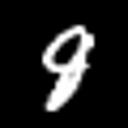

In [215]:
# %%time
image_id = RNG.choice(df_train_images.index)
image_id = 53806
image = Image.open(io.BytesIO(df_train_images.loc[image_id]['png']))
image

In [111]:
cos_sim_mat = SEQ_LVS.array_active @ matchee.seq_lvs.T

In [45]:
matchee = create_matchee(df_train_images.loc[image_id])

In [57]:
xp_array_from_gpu(cos_sim_mat[i,j])

array(0.52802728)

In [60]:
xp.take(cos_sim_ma, top_mat_indices)

array([0.52802728, 0.52805699, 0.52852144, 0.52870091, 0.5288168 ,
       0.52899192, 0.52904237, 0.52910437, 0.5291858 , 0.52921132,
       0.52932992, 0.52981349, 0.52987864, 0.5298983 , 0.53001637,
       0.53091887, 0.53181364, 0.53184084, 0.53200186, 0.53210089,
       0.53222864, 0.53257177, 0.5333655 , 0.53353145, 0.5341961 ,
       0.53454791, 0.53501479, 0.53565665, 0.53640483, 0.53650111,
       0.53715824, 0.53774765, 0.53831506, 0.53844076, 0.53849261,
       0.53886665, 0.53924699, 0.53941241, 0.53971616, 0.53995301,
       0.54011405, 0.54018985, 0.54027345, 0.54049893, 0.54050326,
       0.54052553, 0.54053141, 0.54081165, 0.54082106, 0.54088954,
       0.54119227, 0.54148538, 0.54150746, 0.54151672, 0.54168996,
       0.54189594, 0.54219426, 0.54231309, 0.54250883, 0.54259895,
       0.54268381, 0.54277117, 0.54289654, 0.54373794, 0.54374626,
       0.54377325, 0.54378835, 0.54380495, 0.54387874, 0.54398342,
       0.54403525, 0.5441069 , 0.5442786 , 0.54442379, 0.54472

In [61]:
a1 = np.arange(9).reshape(3, 3)
a1

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

In [69]:
a1.ravel()

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [71]:
np.flip(a1.ravel())

array([8, 7, 6, 5, 4, 3, 2, 1, 0])

In [68]:
type(top_mat_indices)

numpy.ndarray

In [72]:
%%time
inspect_depth = 100

match_tab_columns = defaultdict(list)
cos_sim_mat = SEQ_LVS.array_active @ matchee.seq_lvs.T
top_mat_indices = xp_array_from_gpu(xp.argsort(cos_sim_mat, axis=None)[-inspect_depth:])
cos_sim_values = xp_array_from_gpu(xp.take(cos_sim_mat, top_mat_indices))
top_mat_indices = np.flip(top_mat_indices)
cos_sim_values = np.flip(cos_sim_values)

for top_mat_index, cos_sim_value in zip(top_mat_indices, cos_sim_values):
    i = top_mat_index // cos_sim_mat.shape[1]
    j = top_mat_index % cos_sim_mat.shape[1]
    seq_lv_meta = SEQ_LV_IND_TO_META[i]
    engram = ENGRAMS[seq_lv_meta.engram_id]
    match_tab_columns['engram_seq_lv_ind'].append(i)
    match_tab_columns['matchee_seq_lv_ind'].append(j)
    match_tab_columns['cos_sim'].append(cos_sim_value)
    match_tab_columns['engram_id'].append(engram.engram_id)
    match_tab_columns['engram_value'].append(engram.value)
    match_tab_columns['engram_image_id'].append(engram.image_id)  
    match_tab_columns['engram_phase'].append(seq_lv_meta.phase)
    match_tab_columns['engram_seq_lv_code'].append(seq_lv_meta.seq_lv_code)
    match_tab_columns['matchee_seq_lv_code'].append(matchee.seq_lv_codes[j])

df_match_tab = pd.DataFrame(match_tab_columns)
df_match_tab.head(10)

CPU times: user 8.3 ms, sys: 13.1 ms, total: 21.4 ms
Wall time: 19.4 ms


,engram_seq_lv_ind,matchee_seq_lv_ind,cos_sim,engram_id,engram_value,engram_image_id,engram_phase,engram_seq_lv_code,matchee_seq_lv_code
0,33,813,0.560668,1,4,26704,0,"((2, 0), (0, 0), (1, 1))","((1, 0), (0, 1), (2, 1), (4, 0), (3, 1))"
1,33,812,0.559649,1,4,26704,0,"((2, 0), (0, 0), (1, 1))","((1, 0), (0, 1), (2, 1), (4, 0), (3, 0))"
2,33,815,0.555197,1,4,26704,0,"((2, 0), (0, 0), (1, 1))","((1, 0), (0, 1), (2, 1), (4, 1), (3, 1))"
3,33,814,0.554326,1,4,26704,0,"((2, 0), (0, 0), (1, 1))","((1, 0), (0, 1), (2, 1), (4, 1), (3, 0))"
4,37,2614,0.552823,1,4,26704,0,"((2, 1), (0, 0), (1, 1))","((3, 1), (1, 0), (2, 1), (4, 1), (0, 0))"
5,37,2612,0.552823,1,4,26704,0,"((2, 1), (0, 0), (1, 1))","((3, 1), (1, 0), (2, 1), (4, 0), (0, 0))"
6,33,3149,0.552264,1,4,26704,0,"((2, 0), (0, 0), (1, 1))","((4, 0), (0, 1), (2, 1), (1, 0), (3, 1))"
7,33,3148,0.550657,1,4,26704,0,"((2, 0), (0, 0), (1, 1))","((4, 0), (0, 1), (2, 1), (1, 0), (3, 0))"
8,37,813,0.550207,1,4,26704,0,"((2, 1), (0, 0), (1, 1))","((1, 0), (0, 1), (2, 1), (4, 0), (3, 1))"
9,2,1005,0.550045,1,4,26704,0,"((0, 0), (1, 1), (2, 0))","((1, 0), (2, 1), (0, 1), (4, 0), (3, 1))"


# Test

In [51]:
count = 200
get_test_image_ids = lambda df: RNG.choice(df.index.unique(), min(count, len(df)), replace=False)
TestRunSource = namedtuple('TestRunSource', ['df_images', 'db_con', 'source_ds', 'test_image_ids'])
test_run_source = {
    'test': TestRunSource(df_test_images, test_db_con, 'test', get_test_image_ids(df_test_images)),
    'train': TestRunSource(df_train_images, train_db_con, 'train', get_test_image_ids(df_train_images))
}['test']
test_image_ids = test_run_source.test_image_ids
# test_image_ids = [100007314]
# test_image_ids = train_image_ids

In [68]:
%%time
test_results_db_con.cursor().execute('INSERT INTO test_runs(dummy) VALUES(1)')
test_results_db_con.commit()
test_run_id = test_results_db_con.cursor().execute('SELECT MAX(test_run_id) FROM test_runs').fetchone()[0]
test_result_rows = defaultdict(list)
match_tabs = []

for image_id in tqdm(test_image_ids):
    df_image = test_run_source.df_images.loc[image_id]
    image_value = df_image['value']
    matchee = create_matchee(df_image)
    # df_match_tab = get_match_tab(matchee, compute_diff=False)
    df_match_tab = get_match_tab(matchee) #, inspect_depth=1000)
    df_match_tab['test_image_id'] = image_id
    df_match_tab['true_value'] = image_value
    match_tabs.append(df_match_tab)
    
    # infer_value, engram_image_id, cos_sim, corr, diff_sq = ('', -1, 0, 0, 9999)
    # infer_value, engram_image_id, cos_sim, diff_sq = ('', -1, 0, 9999)
    infer_value, engram_image_id, cos_sim, diff, diff2 = ('', -1, 0, SEQ_LV_LEN * 2 * 2, SEQ_LV_LEN * 2 * 2)
        
    if len(df_match_tab) > 0:
    # if len(df_match_tab) > 0 and df_match_tab.iloc[0]['cos_sim'] > COS_SIM_45:
    # if len(df_match_tab) > 0 and df_match_tab.iloc[0]['cos_sim'] > COS_SIM_30:
    # if len(df_match_tab) > 0 and df_match_tab.iloc[0]['diff'] < 10:
        # infer_value, engram_image_id, cos_sim, corr, diff_sq = df_match_tab.iloc[0][['engram_value', 'engram_image_id', 'cos_sim', 'corr', 'diff_sq']]
        # infer_value, engram_image_id, cos_sim, diff_sq = df_match_tab.iloc[0][['engram_value', 'engram_image_id', 'cos_sim', 'diff_sq']]
        infer_value, engram_image_id, cos_sim, diff, diff2 = df_match_tab.iloc[0][['engram_value', 'engram_image_id', 'cos_sim', 'diff', 'diff2']]
    
    test_result_rows['test_run_id'].append(test_run_id)
    test_result_rows['config_variant'].append(config.section_name)
    test_result_rows['cortical_columns'].append(f'[{','.join([])}]')
    test_result_rows['train_images_count'].append(TRAIN_IMAGES_COUNT)
    test_result_rows['train_runs_count'].append(TRAIN_RUNS_COUNT)
    test_result_rows['source_ds'].append(test_run_source.source_ds)
    test_result_rows['test_image_id'].append(image_id)
    test_result_rows['true_value'].append(image_value)
    test_result_rows['engram_image_id'].append(engram_image_id)
    test_result_rows['infer_value'].append(infer_value)
    test_result_rows['cos_sim'].append(cos_sim)
    test_result_rows['diff'].append(diff)
    test_result_rows['diff2'].append(diff2)
    test_result_rows['match_tab_method'].append('cos_sim')
    test_result_rows['match_tab_index'].append(len(match_tabs) - 1)

df_test_results_for_run = pd.DataFrame(test_result_rows)
df_test_results_for_run['timestamp'] = datetime.datetime.now()

if DBUtils.is_table_exists(test_results_db_con, 'test_results'):
    DBUtils.ensure_table_columns(test_results_db_con, 'test_results', list(df_test_results_for_run.columns))
    
df_test_results_for_run.to_sql(name='test_results', con=test_results_db_con, if_exists='append')
pd.DataFrame({'test_run_id': [test_run_id], 'match_tabs': [pickle.dumps(match_tabs)]}).to_sql(name='test_run_artifacts', con=test_results_db_con, if_exists='append');

  0%|          | 0/200 [00:00<?, ?it/s]

CPU times: user 2min 16s, sys: 431 ms, total: 2min 16s
Wall time: 22.5 s


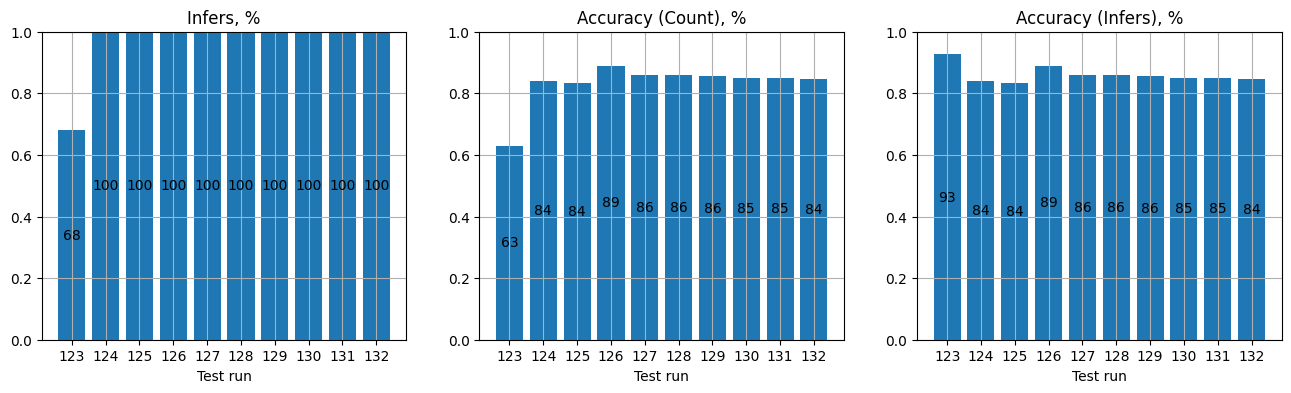

,timestamp,source_ds,train_images_count,count,infers,correct_infers,infer_ratio,accuracy_count,accuracy_infers
test_run_id,,,,,,,,,
123,2025-05-22 11:38:18.867567,test,1040,200,136,126,0.68,0.630,0.926471
124,2025-05-22 12:09:55.339562,test,1038,200,200,168,1.00,0.840,0.840000
125,2025-05-22 12:10:55.599743,test,1038,200,200,167,1.00,0.835,0.835000
126,2025-05-22 12:41:50.837998,test,1038,200,200,178,1.00,0.890,0.890000
127,2025-05-22 13:26:49.272562,test,1044,200,200,172,1.00,0.860,0.860000
128,2025-05-22 13:27:25.356418,test,1044,200,200,172,1.00,0.860,0.860000
129,2025-05-22 13:32:25.428312,test,1030,200,200,171,1.00,0.855,0.855000
130,2025-05-22 13:32:52.164401,test,1030,200,200,170,1.00,0.850,0.850000
131,2025-05-22 13:38:07.661231,test,1035,200,200,170,1.00,0.850,0.850000


In [69]:
df_test_results2 = pd.read_sql_query('''
SELECT * FROM test_results 
WHERE test_run_id IN (SELECT test_run_id FROM test_runs ORDER BY test_run_id DESC LIMIT 10) 
ORDER BY test_run_id ASC
''', con=test_results_db_con)
df_test_results2['test_run_id'] = df_test_results2['test_run_id'].astype(int)
df_test_results2['is_infer'] = df_test_results2['infer_value'] != ''
df_test_results2['is_correct_infer'] = df_test_results2['true_value'] == df_test_results2['infer_value']
df_test_results2 = df_test_results2.groupby(by=['test_run_id']).agg({'timestamp': 'first',
                                                                     'config_variant': 'first', 
                                                                     'source_ds': 'first',
                                                                     'cortical_columns': 'first',
                                                                     'train_images_count': 'first',
                                                                     'train_runs_count': 'first',
                                                                     'test_image_id': 'count', 
                                                                     'is_infer': 'sum', 
                                                                     'is_correct_infer': 'sum'})
df_test_results2.sort_values(by=['test_run_id'], inplace=True)
df_test_results2.rename(columns=dict(test_image_id='count', is_infer='infers', is_correct_infer='correct_infers'), inplace=True, errors='raise')
df_test_results2['infer_ratio'] = df_test_results2['infers'] / df_test_results2['count']
df_test_results2['accuracy_count'] = df_test_results2['correct_infers'] / df_test_results2['count']
df_test_results2['accuracy_infers'] = df_test_results2['correct_infers'] / df_test_results2['infers']
df_test_results2['accuracy_infers'] = df_test_results2['accuracy_infers'].fillna(0)

plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
b = plt.bar(list(map(str, df_test_results2.index)), list(df_test_results2['infer_ratio']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_test_results2['infer_ratio']), label_type='center')
plt.ylim(0, 1)
plt.title('Infers, %')
plt.xlabel('Test run')
plt.grid()

plt.subplot(1, 3, 2)
b = plt.bar(list(map(str, df_test_results2.index)), list(df_test_results2['accuracy_count']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_test_results2['accuracy_count']), label_type='center')
plt.ylim(0, 1)
plt.title('Accuracy (Count), %')
plt.xlabel('Test run')
plt.grid()

plt.subplot(1, 3, 3)
b = plt.bar(list(map(str, df_test_results2.index)), list(df_test_results2['accuracy_infers']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_test_results2['accuracy_infers']), label_type='center')
plt.ylim(0, 1)
plt.title('Accuracy (Infers), %')
plt.xlabel('Test run')
plt.grid()

plt.show()
df_test_results2[['timestamp', 'source_ds', 'train_images_count', 'count', 'infers', 'correct_infers', 'infer_ratio', 'accuracy_count', 'accuracy_infers']]

## analyze

In [210]:
df_incorrect = df_test_results_for_run.loc[df_test_results_for_run.true_value != df_test_results_for_run.infer_value]
df_incorrect = df_incorrect[['test_image_id', 'engram_image_id', 'true_value', 'infer_value', 'cos_sim', 'diff', 'match_tab_index', 'match_tab_method']]
df_incorrect

,test_image_id,engram_image_id,true_value,infer_value,cos_sim,diff,match_tab_index,match_tab_method
1,100005282,-1,2,,0.000000,9000.000000,1,cos_sim
2,100000882,-1,9,,0.000000,9000.000000,2,cos_sim
3,100007136,53806,9,8,0.806397,9.718963,3,cos_sim
4,100001758,-1,8,,0.000000,9000.000000,4,cos_sim
5,100004552,-1,3,,0.000000,9000.000000,5,cos_sim
...,...,...,...,...,...,...,...,...
191,100007974,-1,5,,0.000000,9000.000000,191,cos_sim
192,100004279,-1,2,,0.000000,9000.000000,192,cos_sim
194,100008502,-1,5,,0.000000,9000.000000,194,cos_sim
198,100008598,-1,3,,0.000000,9000.000000,198,cos_sim


In [185]:
df_correct = df_test_results_for_run.loc[df_test_results_for_run.true_value == df_test_results_for_run.infer_value].copy()
# df_correct[['test_image_id', 'true_value', 'engram_image_id', 'infer_value', 'cos_sim', 'corr', 'diff_sq', 'match_tab_index']]
# df_correct[['test_image_id', 'true_value', 'engram_image_id', 'infer_value', 'cos_sim', 'diff_sq', 'match_tab_index', 'match_tab_method']]
df_correct[['test_image_id', 'true_value', 'engram_image_id', 'infer_value', 'cos_sim', 'diff', 'match_tab_index', 'match_tab_method']]

,test_image_id,true_value,engram_image_id,infer_value,cos_sim,diff,match_tab_index,match_tab_method
0,100005957,5,55728,5,0.746873,11.630266,0,cos_sim
1,100006367,4,55736,4,0.831117,8.955546,1,cos_sim
3,100000033,4,8747,4,0.811601,11.200285,3,cos_sim
4,100000173,3,3815,3,0.731768,15.151133,4,cos_sim
5,100002656,0,58754,0,0.888769,7.001492,5,cos_sim
...,...,...,...,...,...,...,...,...
194,100001814,7,101,7,0.846402,7.806480,194,cos_sim
195,100008827,9,31593,9,0.851716,7.979588,195,cos_sim
196,100002152,8,18396,8,0.771250,11.503447,196,cos_sim
198,100009124,1,21477,1,0.957200,2.076942,198,cos_sim


In [186]:
df_correct['diff'].describe()

count    139.000000
mean       9.372205
std        3.541742
min        1.825317
25%        7.127015
50%        9.361514
75%       11.760347
max       18.299835
Name: diff, dtype: float64

In [187]:
df_incorrect['diff'].describe()

count    61.000000
mean     12.929721
std       2.463057
min       7.306510
25%      11.957750
50%      13.411369
75%      14.351492
max      19.549992
Name: diff, dtype: float64

In [216]:
match_tab_index = 199
match_tab = match_tabs[match_tab_index]
#match_tab.head(10)
match_tab.sort_values(by=['cos_sim'], ascending=False)

,engram_seq_lv_ind,matchee_seq_lv_ind,cos_sim,diff,engram_id,engram_value,engram_image_id,engram_seq_lv_code,matchee_seq_lv_code,test_image_id,true_value
0,2369,96,0.828845,9.738722,1408,7,42650,"((1, 0), (0, 0), (2, 0), (3, 0))","((1, 0), (0, 0), (2, 0), (3, 0))",100005720,4
1,2379,256,0.823087,9.562623,1408,7,42650,"((2, 0), (3, 0), (0, 0), (1, 0))","((2, 0), (3, 0), (0, 0), (1, 0))",100005720,4
2,2366,48,0.803717,10.666250,1408,7,42650,"((0, 0), (2, 0), (3, 0), (1, 0))","((0, 0), (2, 0), (3, 0), (1, 0))",100005720,4
3,2222,225,0.803251,10.903639,1403,7,50215,"((2, 0), (0, 0), (1, 0), (3, 0))","((2, 0), (1, 0), (0, 0), (3, 1))",100005720,4
4,2370,112,0.800343,10.867698,1408,7,42650,"((1, 0), (0, 0), (3, 0), (2, 0))","((1, 0), (0, 0), (3, 0), (2, 0))",100005720,4
...,...,...,...,...,...,...,...,...,...,...,...
95,2212,128,0.706597,13.841255,1403,7,50215,"((0, 0), (2, 0), (1, 0), (3, 0))","((1, 0), (2, 0), (0, 0), (3, 0))",100005720,4
96,546,224,0.706135,14.498072,1284,4,2832,"((2, 0), (0, 0), (1, 0))","((2, 0), (1, 0), (0, 0), (3, 0))",100005720,4
97,2383,256,0.705971,14.219621,1408,7,42650,"((3, 0), (1, 0), (0, 0), (2, 0))","((2, 0), (3, 0), (0, 0), (1, 0))",100005720,4
98,2376,209,0.705869,12.402361,1408,7,42650,"((2, 0), (0, 0), (3, 0), (1, 0))","((2, 0), (0, 0), (3, 0), (1, 1))",100005720,4


In [137]:
engram_seq_lv2 = engram_seq_lv2.reshape(-1, 2)
matchee_seq_lv2 = matchee_seq_lv2.reshape(-1, 2)
cos_sims = 0
# sublv_indices = [0, 1, 2, 3, 4]
# sublv_indices = [0]
# sublv_indices = [0, 1, 3]
sublv_indices = [1]

for sublv_index in sublv_indices:
    engram_seq_sublv = engram_seq_lv2[sublv_index*SEQ_SUBLV_LEN:(sublv_index+1)*SEQ_SUBLV_LEN].copy()
    matchee_seq_sublv = matchee_seq_lv2[sublv_index*SEQ_SUBLV_LEN:(sublv_index+1)*SEQ_SUBLV_LEN].copy()
    engram_seq_sublv[0:300] = 0
    matchee_seq_sublv[0:300] = 0
    denom = (np.linalg.norm(engram_seq_sublv) * np.linalg.norm(matchee_seq_sublv))
    cos_sim = 0

    if denom > 0:
        cos_sim = (engram_seq_sublv.ravel() @ matchee_seq_sublv.ravel()) / denom
        
    cos_sims += cos_sim

cos_sims / len(sublv_indices)

np.float64(0.41923177765012415)

In [252]:
sublv_index = 3
engram_seq_lv3 = engram_seq_lv2[(sublv_index)*SEQ_SUBLV_LEN*2:(sublv_index+1)*SEQ_SUBLV_LEN*2].ravel()
matchee_seq_lv3 = matchee_seq_lv2[(sublv_index)*SEQ_SUBLV_LEN*2:(sublv_index+1)*SEQ_SUBLV_LEN*2].ravel()
(engram_seq_lv3 @ matchee_seq_lv3) / (np.linalg.norm(engram_seq_lv3) * np.linalg.norm(matchee_seq_lv3))

np.float32(0.6704118)

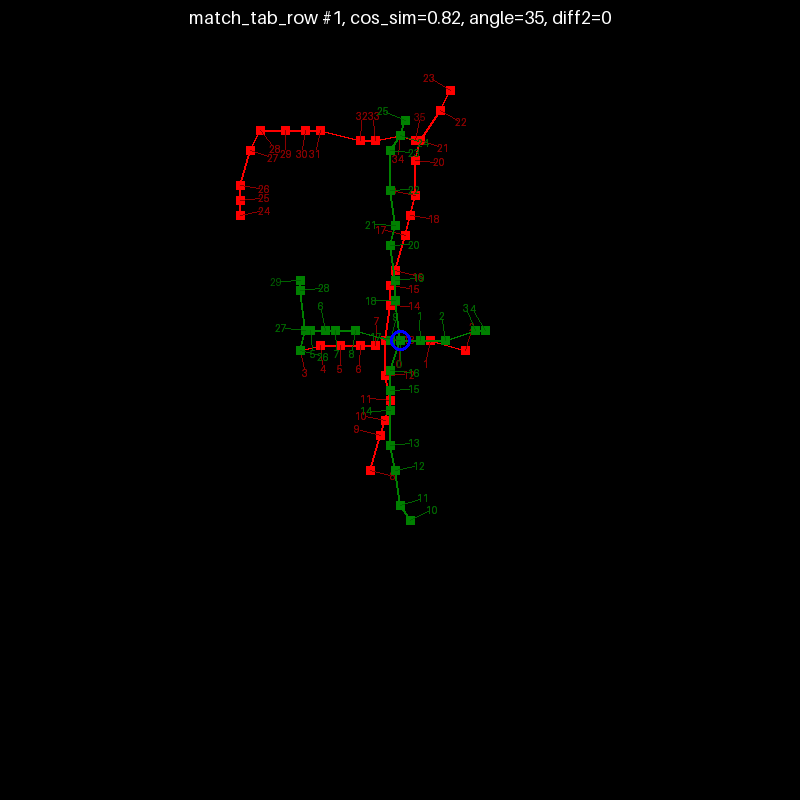

In [220]:
df_match_tab_row = match_tab.iloc[0]
test_image_id = df_match_tab_row['test_image_id']

if test_image_id >= 100_000_000:
    df_test_image = df_test_images.loc[test_image_id]
else:
    df_test_image = df_train_images.loc[test_image_id]

matchee = create_matchee(df_test_image, df_match_tab_row['matchee_seq_lv_code'])
# matchee = create_matchee(df_test_image)

engram_seq_lv_ind = df_match_tab_row['engram_seq_lv_ind']
# engram_seq_lv = SEQ_LVS_COS_SIM.array_active[df_match_tab_row['engram_seq_lv_ind']]
engram_seq_lv = SEQ_LVS.array_active[df_match_tab_row['engram_seq_lv_ind']]
engram_seq_lv2 = SEQ_LVS2.array_active[df_match_tab_row['engram_seq_lv_ind']]

matchee_seq_lv_code = df_match_tab_row['matchee_seq_lv_code']
matchee_seq_lv_ind = matchee.seq_lv_codes.index(matchee_seq_lv_code)
# matchee_seq_lv = matchee.seq_lvs_cos_sim[matchee_seq_lv_ind]
matchee_seq_lv = matchee.seq_lvs[matchee_seq_lv_ind]
matchee_seq_lv2 = matchee.seq_lvs2[matchee_seq_lv_ind]

render_match_tab_row(df_match_tab_row, matchee, use_seq_lv=False, delta_xy = np.array([10, 0]), k=5)

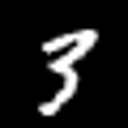

In [213]:
Image.open(io.BytesIO(df_test_images.loc[100003769]['png']))

In [175]:
list(map(lambda kv: kv[1].image_id, filter(lambda kv: kv[1].value == '6', ENGRAMS.items())))

[25959, 46074, 39577, 27536, 39777, 5654]

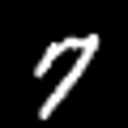

In [212]:
Image.open(io.BytesIO(df_train_images.loc[53171]['png']))

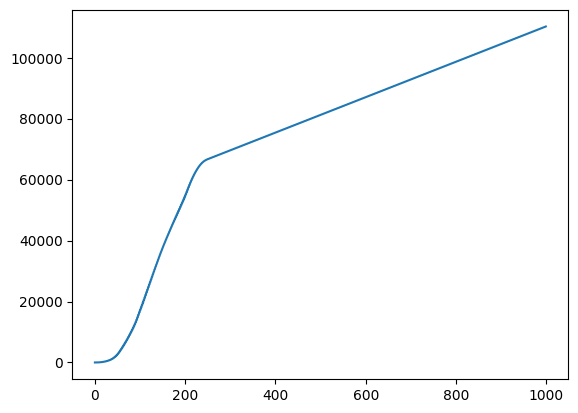

In [128]:
seq_lvs_diff = 0
seq_lvs_diff_cums = []

for vec1, vec2 in zip(engram_seq_lv[:1000], matchee_seq_lv[:1000]):
    vec = vec1 - vec2
    vec = vec ** 2
    seq_lvs_diff += vec.sum()
    seq_lvs_diff_cums.append(seq_lvs_diff)

seq_lvs_diff

plt.plot(seq_lvs_diff_cums)
plt.show()

In [130]:
matchee = create_matchee(df_test_image)
mt = get_match_tab(matchee, inspect_depth=9999999)
# mt[(mt['engram_image_id'] == 39577) & (mt['matchee_seq_lv_code'] == ((1,0), (2,0), (3,0), (0,0)))]
# mt[(mt['engram_image_id'] == 39577) & (mt['matchee_seq_lv_code'] == ((0,0), (1,0)))]
# mt[(mt['matchee_seq_lv_code'] == ((1,0), (0,0)))]
mt[(mt['engram_image_id'] == 5654)]

,engram_seq_lv_ind,matchee_seq_lv_ind,cos_sim,diff_sq,engram_id,engram_value,engram_image_id,engram_phase,engram_seq_lv_code,matchee_seq_lv_code
3718,14157,4,-1,1.065956e+06,46,6,5654,0,"((0, 1), (1, 1))","((1, 0), (0, 0))"
3719,14161,0,-1,1.065956e+06,46,6,5654,0,"((1, 1), (0, 1))","((0, 0), (1, 0))"
3720,14155,6,-1,1.080466e+06,46,6,5654,0,"((0, 0), (1, 1))","((1, 1), (0, 0))"
3721,14160,1,-1,1.080466e+06,46,6,5654,0,"((1, 1), (0, 0))","((0, 0), (1, 1))"
3792,14157,6,-1,1.134638e+06,46,6,5654,0,"((0, 1), (1, 1))","((1, 1), (0, 0))"
...,...,...,...,...,...,...,...,...,...,...
116653,14158,1,-1,7.748395e+06,46,6,5654,0,"((1, 0), (0, 0))","((0, 0), (1, 1))"
116706,14156,6,-1,7.807281e+06,46,6,5654,0,"((0, 1), (1, 0))","((1, 1), (0, 0))"
116707,14159,1,-1,7.807281e+06,46,6,5654,0,"((1, 0), (0, 1))","((0, 0), (1, 1))"
116709,14154,4,-1,7.808612e+06,46,6,5654,0,"((0, 0), (1, 0))","((1, 0), (0, 0))"


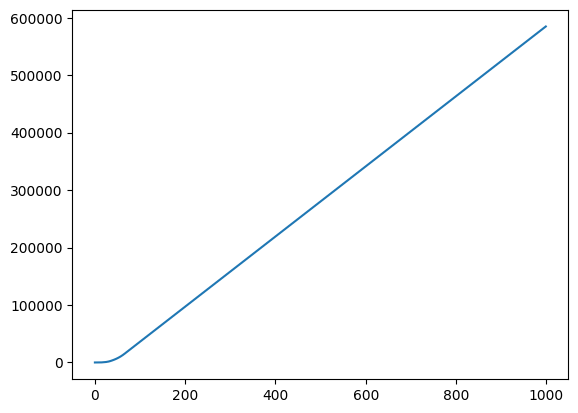

In [131]:
df_match_tab_row = mt.iloc[3718]
engram_seq_lv_ind = df_match_tab_row['engram_seq_lv_ind']
engram_seq_lv = SEQ_LVS_COS_SIM.array_active[df_match_tab_row['engram_seq_lv_ind']]

matchee_seq_lv_code = df_match_tab_row['matchee_seq_lv_code']
matchee_seq_lv_ind = matchee.seq_lv_codes.index(matchee_seq_lv_code)
matchee_seq_lv = matchee.seq_lvs_cos_sim[matchee_seq_lv_ind]

seq_lvs_diff = 0
seq_lvs_diff_cums = []

for vec1, vec2 in zip(engram_seq_lv[:1000], matchee_seq_lv[:1000]):
    vec = vec1 - vec2
    vec = vec ** 2
    seq_lvs_diff += vec.sum()
    seq_lvs_diff_cums.append(seq_lvs_diff)

seq_lvs_diff

plt.plot(seq_lvs_diff_cums)
plt.show()

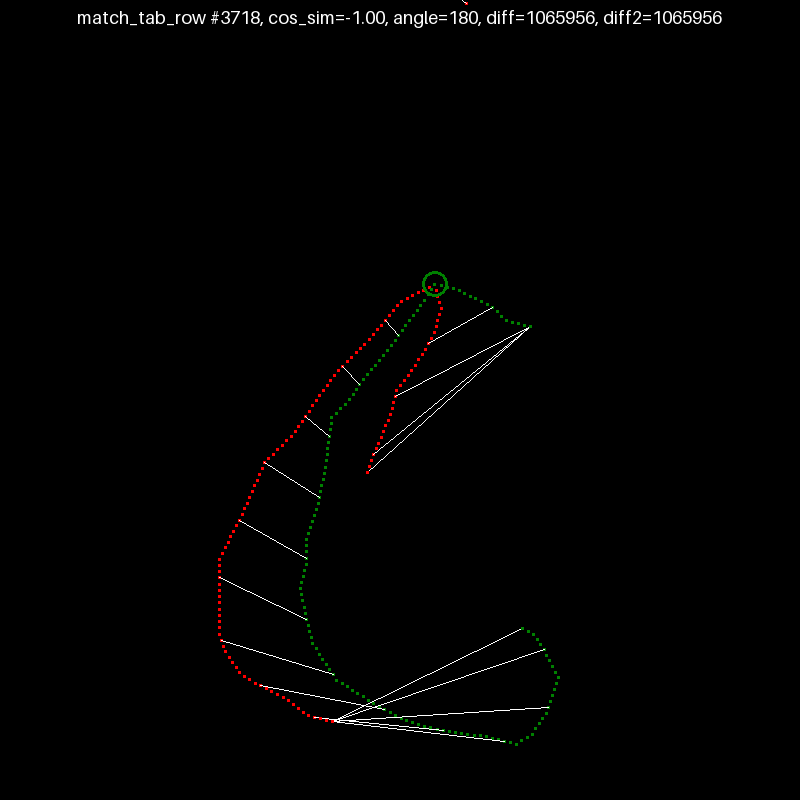

In [132]:
render_match_tab_row(mt.iloc[3718], matchee, use_seq_lv=True) # 1324

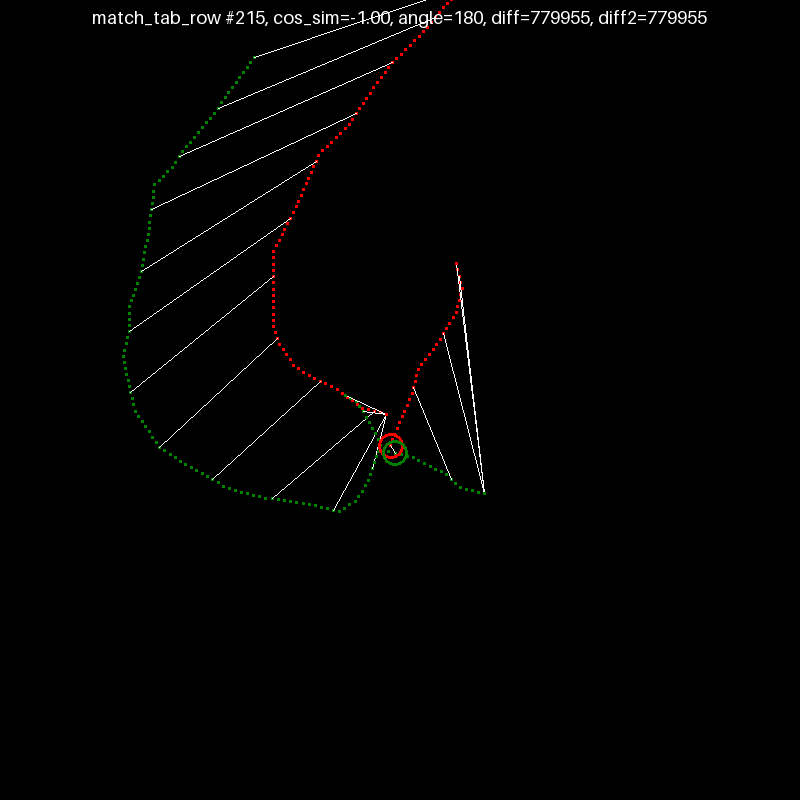

In [306]:
render_match_tab_row(mt.iloc[215], matchee, use_seq_lv=True) # 1324

## xxx

In [203]:
# df_test_results_for_run_c = df_test_results_for_run.copy()

In [204]:
test_run_id_c = int(df_test_results_for_run_c['test_run_id'][0])
match_tabs_c = pickle.loads(pd.read_sql(f'SELECT match_tabs FROM test_run_artifacts WHERE test_run_id = {test_run_id_c}', con=test_results_db_con).iloc[0]['match_tabs'])

In [206]:
df_incorrect_c = df_test_results_for_run_c.loc[df_test_results_for_run_c.true_value != df_test_results_for_run_c.infer_value]
df_incorrect_c = df_incorrect_c[['test_image_id', 'engram_image_id', 'true_value', 'infer_value', 'cos_sim', 'match_tab_index', 'match_tab_method']]
df_correct_c = df_test_results_for_run_c.loc[df_test_results_for_run_c.true_value == df_test_results_for_run_c.infer_value].copy()
df_correct_c = df_correct_c[['test_image_id', 'engram_image_id', 'true_value', 'infer_value', 'cos_sim', 'match_tab_index', 'match_tab_method']]
df_incorrect_c.head()

,test_image_id,engram_image_id,true_value,infer_value,cos_sim,match_tab_index,match_tab_method
0,100003752,29437,4,6,0.841084,0,cos_sim
1,100001264,9758,4,9,0.893869,1,cos_sim
7,100009710,44106,6,5,0.807008,7,cos_sim
21,100001178,1033,4,2,0.788638,21,cos_sim
38,100001012,9484,7,2,0.821328,38,cos_sim


In [207]:
df_correct_c.head()

,test_image_id,engram_image_id,true_value,infer_value,cos_sim,match_tab_index,match_tab_method
2,100005629,38800,2,2,0.776715,2,cos_sim
3,100007696,56698,4,4,0.876949,3,cos_sim
4,100000111,43598,7,7,0.907990,4,cos_sim
5,100001435,42773,9,9,0.756153,5,cos_sim
6,100007232,15507,1,1,0.875834,6,cos_sim


In [257]:
df_incorrect = df_test_results_for_run.loc[df_test_results_for_run.true_value != df_test_results_for_run.infer_value]
df_incorrect = df_incorrect[['test_image_id', 'engram_image_id', 'true_value', 'infer_value', 'cos_sim', 'match_tab_index', 'match_tab_method']]
df_incorrect.head()

,test_image_id,engram_image_id,true_value,infer_value,cos_sim,match_tab_index,match_tab_method
8,100007903,3924,7,2,0.773791,8,cos_sim
12,100004207,29437,8,6,0.734214,12,cos_sim
18,100008928,6448,9,4,0.733242,18,cos_sim
20,100007613,42349,6,0,0.774789,20,cos_sim
37,100001012,57752,7,2,0.768041,37,cos_sim


In [258]:
set(df_incorrect['test_image_id']) - set(df_incorrect_c['test_image_id'])#, set(df_incorrect_c['test_image_id']) - set(df_incorrect['test_image_id'])

{100000900,
 100001017,
 100001099,
 100003279,
 100003728,
 100004015,
 100006248,
 100006294,
 100006833,
 100006850,
 100006972,
 100007613,
 100007747,
 100008495}

In [259]:
df_incorrect[df_incorrect['test_image_id'] == 100000900]

,test_image_id,engram_image_id,true_value,infer_value,cos_sim,match_tab_index,match_tab_method
63,100000900,50564,1,4,0.835808,63,cos_sim


In [260]:
df_correct_c[df_correct_c['test_image_id'] == 100000900]

,test_image_id,engram_image_id,true_value,infer_value,cos_sim,match_tab_index,match_tab_method
145,100000900,15730,1,1,0.857304,145,cos_sim


In [218]:
# list(filter(lambda kv: kv[1].image_id == 15730,  ENGRAMS.items()))

In [261]:
mt = match_tabs[63]
mt[mt['engram_image_id'] == 15730]
# mt

,engram_seq_lv_ind,matchee_seq_lv_ind,cos_sim,engram_id,engram_value,engram_image_id,engram_phase,engram_seq_lv_code,matchee_seq_lv_code,test_image_id,true_value
2,2418,24,0.820190,3086,1,15730,0,"((1, 0), (2, 0), (0, 0))","((1, 0), (2, 0), (0, 0))",100000900,1
3,2417,16,0.795339,3086,1,15730,0,"((1, 0), (0, 0), (2, 0))","((1, 0), (0, 0), (2, 0))",100000900,1
4,2415,0,0.783616,3086,1,15730,0,"((0, 0), (1, 0), (2, 0))","((0, 0), (1, 0), (2, 0))",100000900,1
5,2420,40,0.781336,3086,1,15730,0,"((2, 0), (1, 0), (0, 0))","((2, 0), (1, 0), (0, 0))",100000900,1
7,2419,32,0.764612,3086,1,15730,0,"((2, 0), (0, 0), (1, 0))","((2, 0), (0, 0), (1, 0))",100000900,1
46,2420,24,0.697691,3086,1,15730,0,"((2, 0), (1, 0), (0, 0))","((1, 0), (2, 0), (0, 0))",100000900,1
48,2417,32,0.696572,3086,1,15730,0,"((1, 0), (0, 0), (2, 0))","((2, 0), (0, 0), (1, 0))",100000900,1
58,2419,16,0.684397,3086,1,15730,0,"((2, 0), (0, 0), (1, 0))","((1, 0), (0, 0), (2, 0))",100000900,1
76,2416,8,0.676281,3086,1,15730,0,"((0, 0), (2, 0), (1, 0))","((0, 0), (2, 0), (1, 0))",100000900,1
99,2416,0,0.659447,3086,1,15730,0,"((0, 0), (2, 0), (1, 0))","((0, 0), (1, 0), (2, 0))",100000900,1


In [262]:
match_tabs_c[145]

,engram_seq_lv_ind,matchee_seq_lv_ind,cos_sim,engram_id,engram_value,engram_image_id,engram_phase,engram_seq_lv_code,matchee_seq_lv_code,test_image_id,true_value
0,56975,33,0.857304,2577,1,15730,0,"((2, 0), (0, 0), (1, 1))","((2, 0), (0, 0), (1, 1))",100000900,1
1,56977,35,0.845943,2577,1,15730,0,"((2, 0), (0, 1), (1, 1))","((2, 0), (0, 1), (1, 1))",100000900,1
2,56957,15,0.844402,2577,1,15730,0,"((0, 1), (2, 1), (1, 1))","((0, 1), (2, 1), (1, 1))",100000900,1
3,56961,19,0.837876,2577,1,15730,0,"((1, 0), (0, 1), (2, 1))","((1, 0), (0, 1), (2, 1))",100000900,1
4,56532,0,0.835808,2572,4,50564,0,"((2, 0), (1, 0), (0, 0))","((0, 0), (1, 0), (2, 0))",100000900,1
...,...,...,...,...,...,...,...,...,...,...,...
95,29075,33,0.743445,2526,2,24035,0,"((0, 0), (3, 0), (1, 1), (4, 0), (2, 1))","((2, 0), (0, 0), (1, 1))",100000900,1
96,29045,33,0.743445,2526,2,24035,0,"((0, 0), (3, 0), (1, 1), (2, 1), (4, 1))","((2, 0), (0, 0), (1, 1))",100000900,1
97,29044,33,0.743445,2526,2,24035,0,"((0, 0), (3, 0), (1, 1), (2, 1), (4, 0))","((2, 0), (0, 0), (1, 1))",100000900,1
98,28627,7,0.743371,2524,1,57931,0,"((1, 1), (0, 1), (2, 1))","((0, 1), (1, 1), (2, 1))",100000900,1


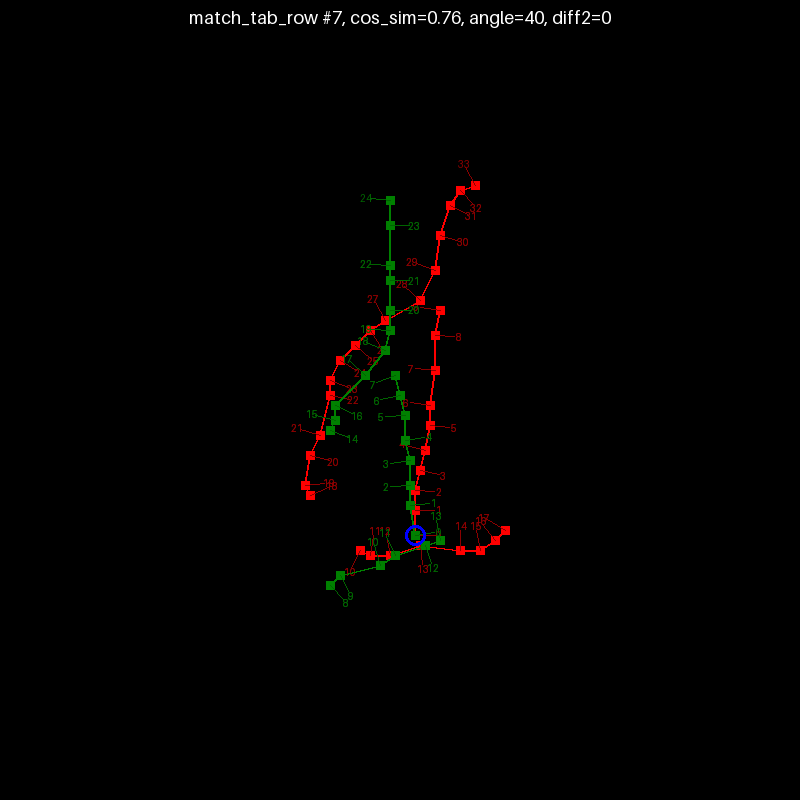

In [264]:
match_tab = match_tabs[63]
df_match_tab_row = match_tab.iloc[7]
test_image_id = df_match_tab_row['test_image_id']

if test_image_id >= 100_000_000:
    df_test_image = df_test_images.loc[test_image_id]
else:
    df_test_image = df_train_images.loc[test_image_id]

matchee = create_matchee(df_test_image, df_match_tab_row['matchee_seq_lv_code'])
# matchee = create_matchee(df_test_image)

engram_seq_lv_ind = df_match_tab_row['engram_seq_lv_ind']
# engram_seq_lv = SEQ_LVS_COS_SIM.array_active[df_match_tab_row['engram_seq_lv_ind']]
engram_seq_lv = SEQ_LVS.array_active[df_match_tab_row['engram_seq_lv_ind']]
engram_seq_lv2 = SEQ_LVS2.array_active[df_match_tab_row['engram_seq_lv_ind']]

matchee_seq_lv_code = df_match_tab_row['matchee_seq_lv_code']
matchee_seq_lv_ind = matchee.seq_lv_codes.index(matchee_seq_lv_code)
# matchee_seq_lv = matchee.seq_lvs_cos_sim[matchee_seq_lv_ind]
matchee_seq_lv = matchee.seq_lvs[matchee_seq_lv_ind]
matchee_seq_lv2 = matchee.seq_lvs2[matchee_seq_lv_ind]

render_match_tab_row(df_match_tab_row, matchee, use_seq_lv=False, delta_xy = np.array([10, 15]), k=5)

In [246]:
seq_sublv_i = 0
engram_seq_lv2.reshape(-1, 2)[SEQ_SUBLV_LEN*seq_sublv_i:SEQ_SUBLV_LEN*(seq_sublv_i+1)].ravel() @ matchee_seq_lv2.reshape(-1, 2)[SEQ_SUBLV_LEN*seq_sublv_i:SEQ_SUBLV_LEN*(seq_sublv_i+1)].ravel()

np.float32(30.74998)

In [251]:
engram_seq_lv2.reshape(-1, 2)[SEQ_SUBLV_LEN*seq_sublv_i:SEQ_SUBLV_LEN*(seq_sublv_i+1)][100:]

array([[ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,

In [245]:
matchee_seq_lv2.reshape(-1, 2)[SEQ_SUBLV_LEN*seq_sublv_i:SEQ_SUBLV_LEN*(seq_sublv_i+1)][:50]

array([[-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,